## Business Problem/Challenge:
Our objective is to develop a robust system for accurately valuing soccer players. This system will guide teams in making informed decisions about which players to buy and sell (known as transfer decisions). Effective transfer policy can mean a financial difference of hundreds of millions of pounds, making accurate player valuation critical to a club's long-term prosperity.

## Summary
This project successfully developed a dual-purpose system to analyze the football transfer market.

A supervised XGBoost model was built to predict player market values, achieving a strong R-squared of 0.72. Its primary function is to replicate and challenge expert valuations, identifying players the model flags as potentially under- or over-valued. This is complemented by an unsupervised K-Means clustering model that segments players into distinct statistical archetypes (e.g., "Elite Superstars," "Young Prospects"), providing a powerful framework for scouting and deeper player analysis.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import warnings
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from xgboost import XGBRegressor

In [77]:
path = '../Data'

csv_files = glob.glob(path + "/*.csv")
to_remove = ['../Data/game_lineups.csv',
             '../Data/game_events.csv'
            ]
csv_files = [x for x in csv_files if x not in to_remove]

# Create an empty dictionary to store the DataFrames
dataframes = {}

for file in csv_files:
  # Get the base name of the file
  base_name = os.path.basename(file)
  
  # Remove the .csv extension to get the clean name
  # and add '_df' to match your requested format
  df_name = f"{os.path.splitext(base_name)[0]}_df"
  
  # Read the csv and add it to the dictionary
  dataframes[df_name] = pd.read_csv(file)

print("Available DataFrames:", list(dataframes.keys()))

Available DataFrames: ['competitions_df', 'appearances_df', 'player_valuations_df', 'transfers_df', 'players_df', 'games_df', 'club_games_df', 'clubs_df']


In [3]:
# Unpack the dictionary into separate global variables
for name, df in dataframes.items():
  globals()[name] = df

In [4]:
competitions_df.head()

,competition_id,competition_code,name,sub_type,type,country_id,country_name,domestic_league_code,confederation,url,is_major_national_league
0,CIT,italy-cup,italy-cup,domestic_cup,domestic_cup,75,Italy,IT1,europa,https://www.transfermarkt.co.uk/italy-cup/star...,False
1,NLSC,johan-cruijff-schaal,johan-cruijff-schaal,domestic_super_cup,other,122,Netherlands,NL1,europa,https://www.transfermarkt.co.uk/johan-cruijff-...,False
2,GRP,kypello-elladas,kypello-elladas,domestic_cup,domestic_cup,56,Greece,GR1,europa,https://www.transfermarkt.co.uk/kypello-ellada...,False
3,POSU,supertaca-candido-de-oliveira,supertaca-candido-de-oliveira,domestic_super_cup,other,136,Portugal,PO1,europa,https://www.transfermarkt.co.uk/supertaca-cand...,False
4,RUSS,russian-super-cup,russian-super-cup,domestic_super_cup,other,141,Russia,RU1,europa,https://www.transfermarkt.co.uk/russian-super-...,False


In [5]:
for name, df_object in dataframes.items():
    print(f"--- Analyzing: {name} ---")
    print("Head:")
    print(df_object.head())
    print("\nInfo:")
    df_object.info()
    print("\nDescribe:")
    print(df_object.describe())
    print("\n" + "="*50 + "\n")

--- Analyzing: competitions_df ---
Head:
  competition_id               competition_code  \
0            CIT                      italy-cup   
1           NLSC           johan-cruijff-schaal   
2            GRP                kypello-elladas   
3           POSU  supertaca-candido-de-oliveira   
4           RUSS              russian-super-cup   

                            name            sub_type          type  \
0                      italy-cup        domestic_cup  domestic_cup   
1           johan-cruijff-schaal  domestic_super_cup         other   
2                kypello-elladas        domestic_cup  domestic_cup   
3  supertaca-candido-de-oliveira  domestic_super_cup         other   
4              russian-super-cup  domestic_super_cup         other   

   country_id country_name domestic_league_code confederation  \
0          75        Italy                  IT1        europa   
1         122  Netherlands                  NL1        europa   
2          56       Greece          

In [6]:
#Dropping unsued columns
players_df.drop(columns = ['first_name', 'last_name','player_code', 'image_url', 'url'], inplace = True)
competitions_df.drop(columns = ['competition_code','sub_type', 'url'], inplace=True)
clubs_df.drop(columns = ['filename', 'url'], inplace=True)

In [7]:
for name, df_object in dataframes.items():
    print(f"--- Null Rows for {name} ---")
    null_rows = df_object[df_object.isnull().any(axis=1)]
    print(null_rows)

--- Null Rows for competitions_df ---
   competition_id                                         name  \
6             USC                               uefa-super-cup   
8              EL                                europa-league   
17           UCOL                       uefa-conference-league   
18            ELQ                  europa-league-qualifikation   
21           ECLQ  uefa-europa-conference-league-qualifikation   
27             CL                        uefa-champions-league   
32           KLUB                                 fifa-klub-wm   
38            CLQ          uefa-champions-league-qualifikation   

                 type  country_id country_name domestic_league_code  \
6   international_cup          -1          NaN                  NaN   
8   international_cup          -1          NaN                  NaN   
17  international_cup          -1          NaN                  NaN   
18  international_cup          -1          NaN                  NaN   
21  internat

### Notes: 
Null rows for competitions are international (rightfully N/A)

Six appearances rows for copa del rey cup do not have player names, but do have IDs. Can drop

For transfers_df, many null transfer fee and market_value_in_eur. May drop or impute missing values later.

For players_df, many null values. About half of agent_names are missing, contract_expiration_date also has high NaN %. Will need to examine separately. 

For clubs_df, some missing values including a completely NaN total_market_value and coach_name value. Will also need to look at separately.

In [8]:
appearances_df.dropna(inplace=True)

In [9]:
players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav Klose,2015,398,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.00,NaN,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,"1,000,000.00","30,000,000.00"
1,26,Roman Weidenfeller,2017,16,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.00,NaN,Neubauer 13 GmbH,L1,Borussia Dortmund,"750,000.00","8,000,000.00"
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,NaN,NaN,NaN,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,"1,000,000.00","34,500,000.00"
3,77,Lúcio,2012,506,Brazil,Brasília,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,NaN,NaN,NaN,NaN,IT1,Juventus Football Club,"200,000.00","24,500,000.00"
4,80,Tom Starke,2017,27,East Germany (GDR),Freital,Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.00,NaN,IFM,L1,FC Bayern München,"100,000.00","3,000,000.00"


In [10]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32601 entries, 0 to 32600
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             32601 non-null  int64  
 1   name                                  32601 non-null  object 
 2   last_season                           32601 non-null  int64  
 3   current_club_id                       32601 non-null  int64  
 4   country_of_birth                      29802 non-null  object 
 5   city_of_birth                         30146 non-null  object 
 6   country_of_citizenship                32218 non-null  object 
 7   date_of_birth                         32554 non-null  object 
 8   sub_position                          32421 non-null  object 
 9   position                              32601 non-null  object 
 10  foot                                  30065 non-null  object 
 11  height_in_cm   

In [11]:
players_df.isnull().sum()

player_id                                   0
name                                        0
last_season                                 0
current_club_id                             0
country_of_birth                         2799
city_of_birth                            2455
country_of_citizenship                    383
date_of_birth                              47
sub_position                              180
position                                    0
foot                                     2536
height_in_cm                             2256
contract_expiration_date                12091
agent_name                              16019
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur                      1523
highest_market_value_in_eur              1523
dtype: int64

In [12]:
# Create a boolean mask where the condition is True
mask = players_df['country_of_birth'] == players_df['country_of_citizenship']

# Sum the True values (since True=1, False=0) to get the count
count = mask.sum()

print(f"Number of rows where birth country equals citizenship: {count}")

Number of rows where birth country equals citizenship: 24677


In [13]:
players_df['country_of_birth'] = players_df['country_of_birth'].fillna(players_df['country_of_citizenship'])

In [14]:
players_df.isnull().sum()

player_id                                   0
name                                        0
last_season                                 0
current_club_id                             0
country_of_birth                          382
city_of_birth                            2455
country_of_citizenship                    383
date_of_birth                              47
sub_position                              180
position                                    0
foot                                     2536
height_in_cm                             2256
contract_expiration_date                12091
agent_name                              16019
current_club_domestic_competition_id        0
current_club_name                           0
market_value_in_eur                      1523
highest_market_value_in_eur              1523
dtype: int64

In [15]:
players_df = players_df.dropna(subset=['country_of_birth', 'country_of_citizenship'])

In [16]:
players_df['country_of_birth'][players_df['city_of_birth'].isna()].value_counts()

country_of_birth
Denmark        507
Belgium        369
Greece         183
Ukraine        141
Netherlands    141
              ... 
Angola           1
Luxembourg       1
Japan            1
Chile            1
Moldova          1
Name: count, Length: 87, dtype: int64

city_of_birth is probably too granular than what we need, and does not seem to be randomly missing. Dropping column

In [17]:
players_df = players_df.drop(columns=['city_of_birth'])

In [18]:
players_df['position'][players_df['sub_position'].isna()].value_counts()

position
Missing    180
Name: count, dtype: int64

In [19]:
players_df = players_df.dropna(subset=['position', 'sub_position'])

In [20]:
players_df = players_df.dropna(subset=['date_of_birth'])

In [21]:
players_df['sub_position'][players_df['foot'].isna()].value_counts()

sub_position
Goalkeeper            529
Centre-Back           388
Centre-Forward        381
Central Midfield      298
Defensive Midfield    158
Attacking Midfield    156
Left Winger           137
Right-Back             98
Right Winger           95
Left-Back              82
Left Midfield          27
Right Midfield         27
Second Striker         11
Name: count, dtype: int64

In [22]:
players_df['foot'].value_counts()

foot
right    20835
left      7412
both      1363
Name: count, dtype: int64

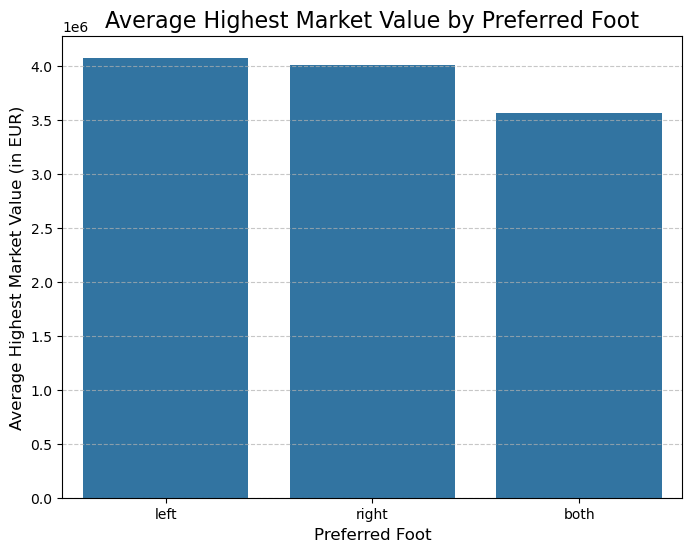

In [23]:
# Group by 'foot' and calculate the mean of the highest market value
avg_value_by_foot = players_df.groupby('foot')['highest_market_value_in_eur'].mean().reset_index()

# Sort the values for a cleaner plot
avg_value_by_foot = avg_value_by_foot.sort_values('highest_market_value_in_eur', ascending=False)


# --- Plotting ---
plt.figure(figsize=(8, 6))
sns.barplot(x='foot', y='highest_market_value_in_eur', data=avg_value_by_foot)

plt.title('Average Highest Market Value by Preferred Foot', fontsize=16)
plt.xlabel('Preferred Foot', fontsize=12)
plt.ylabel('Average Highest Market Value (in EUR)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [24]:
avg_value_by_foot

,foot,highest_market_value_in_eur
1,left,"4,072,431.81"
2,right,"4,003,072.24"
0,both,"3,564,317.16"


In [25]:
#too many values to drop, going to impute 'unknown' cat
players_df['foot'] = players_df['foot'].fillna('Unknown')

In [26]:
#height_in_cm can be replaced with averages. 
#Since players' positions can be a good indicator of height, we'll use average by sub_position
imputed_height = players_df.groupby('sub_position')['height_in_cm'].transform('mean')

# Fill the NaN values in the original column using this new series
players_df['height_in_cm'] = players_df['height_in_cm'].fillna(imputed_height)

In [27]:
# Get today's date
today = pd.to_datetime('today')

# Ensure the contract expiration date column is in datetime format
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])


# --- 1. Feature Engineering: Calculate Contract Days Remaining ---
# Create a new feature for the number of days left on the contract from today
players_df['contract_days_remaining'] = (players_df['contract_expiration_date'] - today).dt.days


# --- 2. Handle the Missing Values ---

# Step A: Create a binary flag for missing contract data
players_df['contract_info_missing'] = players_df['contract_days_remaining'].isnull().astype(int)


# Step B: Impute the missing values in the 'contract_days_remaining' column
# Filling with the median is a robust choice
median_contract_days = players_df['contract_days_remaining'].median()
players_df['contract_days_remaining'] = players_df['contract_days_remaining'].fillna(median_contract_days)


# Drop the original, less useful date column.
players_df = players_df.drop(columns=['contract_expiration_date'])

players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,contract_days_remaining,contract_info_missing
0,10,Miroslav Klose,2015,398,Poland,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.00,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,"1,000,000.00","30,000,000.00",-27.00,1
1,26,Roman Weidenfeller,2017,16,Germany,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.00,Neubauer 13 GmbH,L1,Borussia Dortmund,"750,000.00","8,000,000.00",-27.00,1
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,Unknown,184.04,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,"1,000,000.00","34,500,000.00",-27.00,1
3,77,Lúcio,2012,506,Brazil,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,Unknown,187.36,NaN,IT1,Juventus Football Club,"200,000.00","24,500,000.00",-27.00,1
4,80,Tom Starke,2017,27,East Germany (GDR),Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.00,IFM,L1,FC Bayern München,"100,000.00","3,000,000.00",-27.00,1


In [28]:
players_df['agent_name'] = players_df['agent_name'].fillna('Unknown')

In [29]:
players_df.isnull().sum()

player_id                                  0
name                                       0
last_season                                0
current_club_id                            0
country_of_birth                           0
country_of_citizenship                     0
date_of_birth                              0
sub_position                               0
position                                   0
foot                                       0
height_in_cm                               0
agent_name                                 0
current_club_domestic_competition_id       0
current_club_name                          0
market_value_in_eur                     1413
highest_market_value_in_eur             1413
contract_days_remaining                    0
contract_info_missing                      0
dtype: int64

I'm going to drop highest_market_value_in_eur. The goal is to effectively model player values, and this will lead to leakage. 

In [30]:
players_df = players_df.drop(columns=['highest_market_value_in_eur'])

In [31]:
players_df = players_df.dropna(subset=['market_value_in_eur'])

In [32]:
players_df.head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing
0,10,Miroslav Klose,2015,398,Poland,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.00,ASBW Sport Marketing,IT1,Società Sportiva Lazio S.p.A.,"1,000,000.00",-27.00,1
1,26,Roman Weidenfeller,2017,16,Germany,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.00,Neubauer 13 GmbH,L1,Borussia Dortmund,"750,000.00",-27.00,1
2,65,Dimitar Berbatov,2015,1091,Bulgaria,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,Unknown,184.04,CSKA-AS-23 Ltd.,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,"1,000,000.00",-27.00,1
3,77,Lúcio,2012,506,Brazil,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,Unknown,187.36,Unknown,IT1,Juventus Football Club,"200,000.00",-27.00,1
4,80,Tom Starke,2017,27,East Germany (GDR),Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.00,IFM,L1,FC Bayern München,"100,000.00",-27.00,1


We can grab some new features from other dfs

In [33]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [34]:
#Get totals for stats from appearances_df
sum_cols = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played']

player_stats = appearances_df.groupby('player_id')[sum_cols].sum()
players_df = pd.merge(players_df, player_stats, on='player_id', how='left')
players_df[sum_cols] = players_df[sum_cols].fillna(0)

In [35]:
players_df.sort_values('goals', ascending=False).head()

,player_id,name,last_season,current_club_id,country_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played
3223,38253,Robert Lewandowski,2024,131,Poland,Poland,1988-08-21 00:00:00,Centre-Forward,Attack,right,185.00,Gol International,ES1,Futbol Club Barcelona,"15,000,000.00",338.00,0,59.00,1.00,507.00,118.00,"51,228.00"
2325,28003,Lionel Messi,2022,583,Argentina,Argentina,1987-06-24 00:00:00,Right Winger,Attack,left,170.00,Unknown,FR1,Paris Saint-Germain Football Club,"35,000,000.00",-27.00,1,49.00,1.00,451.00,224.00,"44,380.00"
747,8198,Cristiano Ronaldo,2022,985,Portugal,Portugal,1985-02-05 00:00:00,Centre-Forward,Attack,right,187.00,Gestifute,GB1,Manchester United Football Club,"15,000,000.00",-27.00,0,64.00,4.00,432.00,114.00,"41,150.00"
9295,132098,Harry Kane,2024,27,England,England,1993-07-28 00:00:00,Centre-Forward,Attack,right,188.00,CK66,L1,FC Bayern München,"90,000,000.00",703.00,0,52.00,0.00,346.00,85.00,"39,942.00"
5140,58864,Pierre-Emerick Aubameyang,2023,244,France,Gabon,1989-06-18 00:00:00,Centre-Forward,Attack,right,187.00,Unknown,FR1,Olympique de Marseille,"5,000,000.00",338.00,0,36.00,1.00,294.00,80.00,"38,613.00"


In [36]:
players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])

In [37]:
players_df['age_in_days'] = (today - players_df['date_of_birth']).dt.days
players_df = players_df.drop(columns=['date_of_birth'])

In [38]:
players_df.columns

Index(['player_id', 'name', 'last_season', 'current_club_id',
       'country_of_birth', 'country_of_citizenship', 'sub_position',
       'position', 'foot', 'height_in_cm', 'agent_name',
       'current_club_domestic_competition_id', 'current_club_name',
       'market_value_in_eur', 'contract_days_remaining',
       'contract_info_missing', 'yellow_cards', 'red_cards', 'goals',
       'assists', 'minutes_played', 'age_in_days'],
      dtype='object')

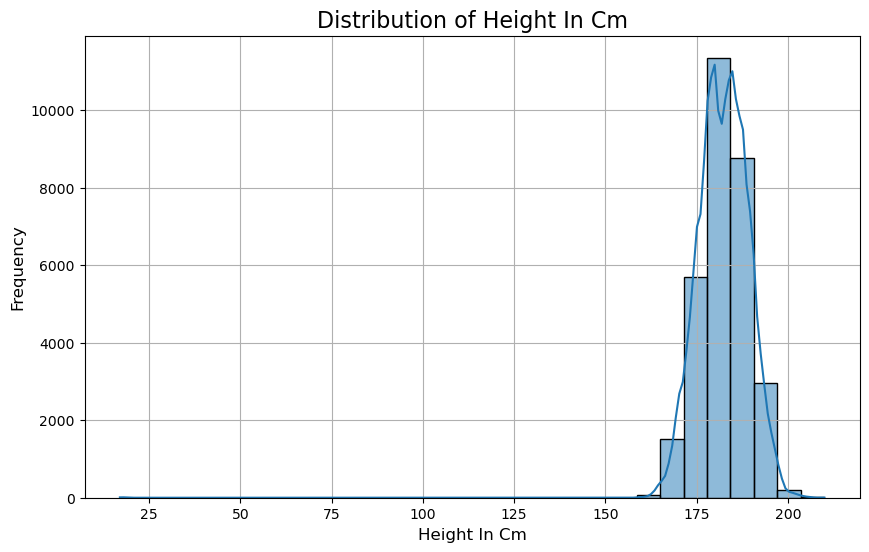

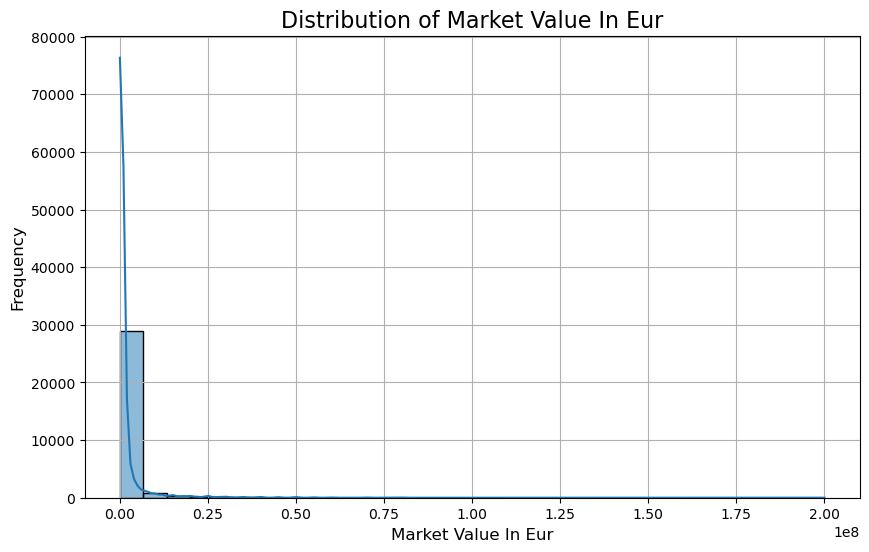

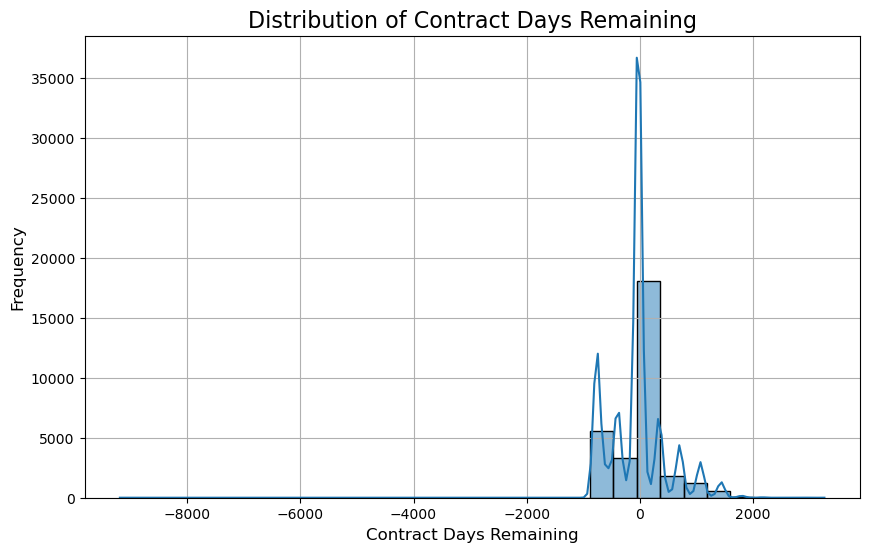

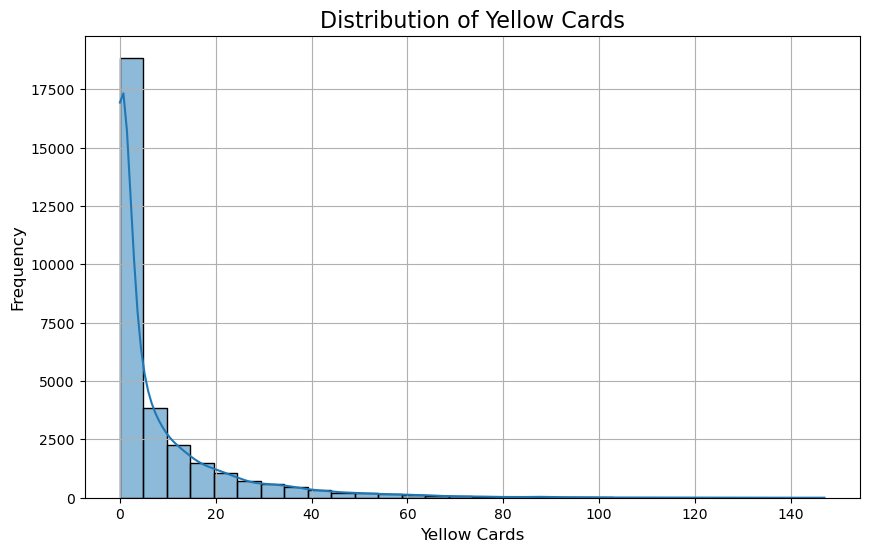

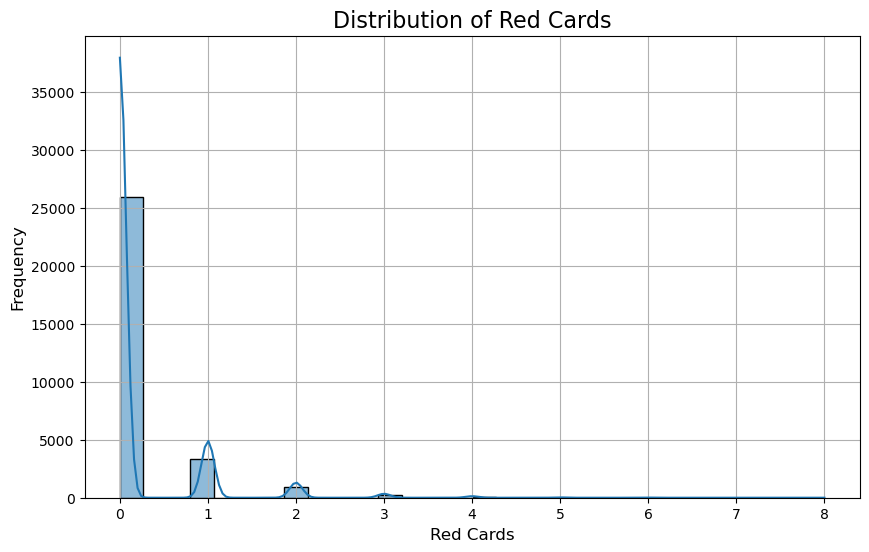

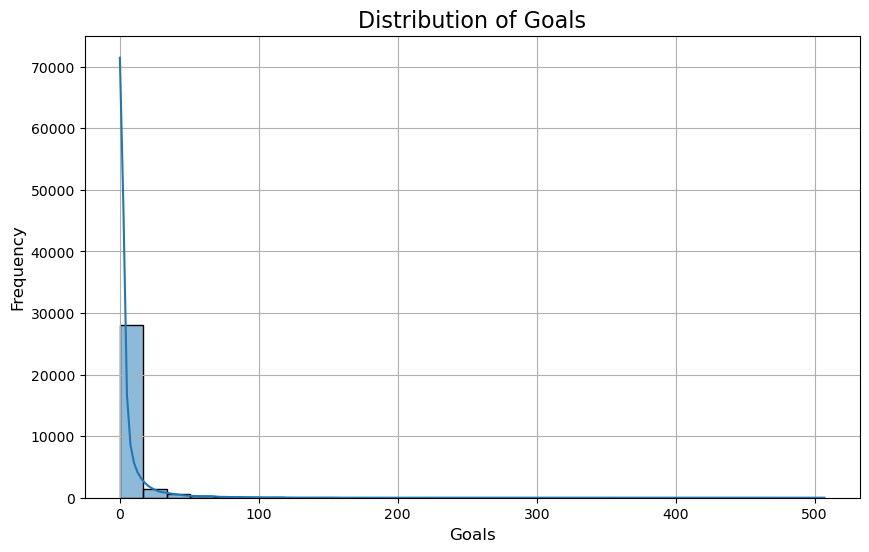

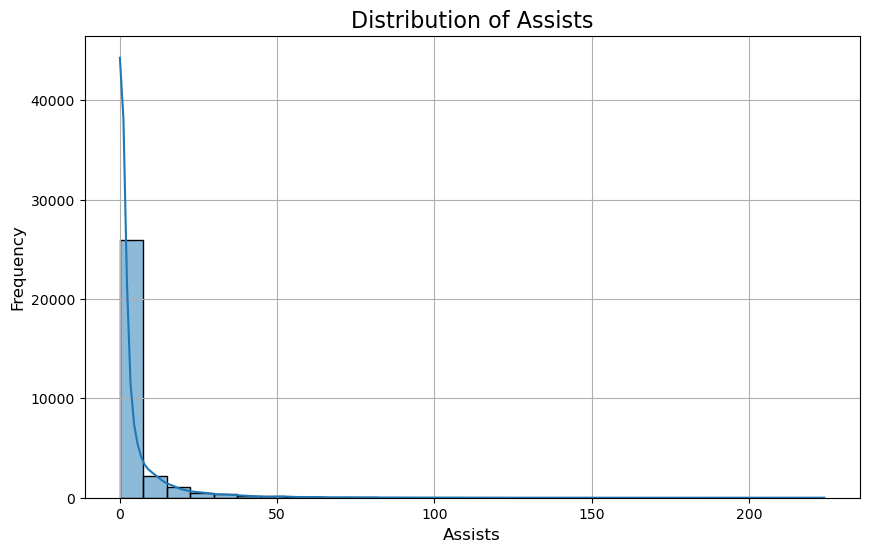

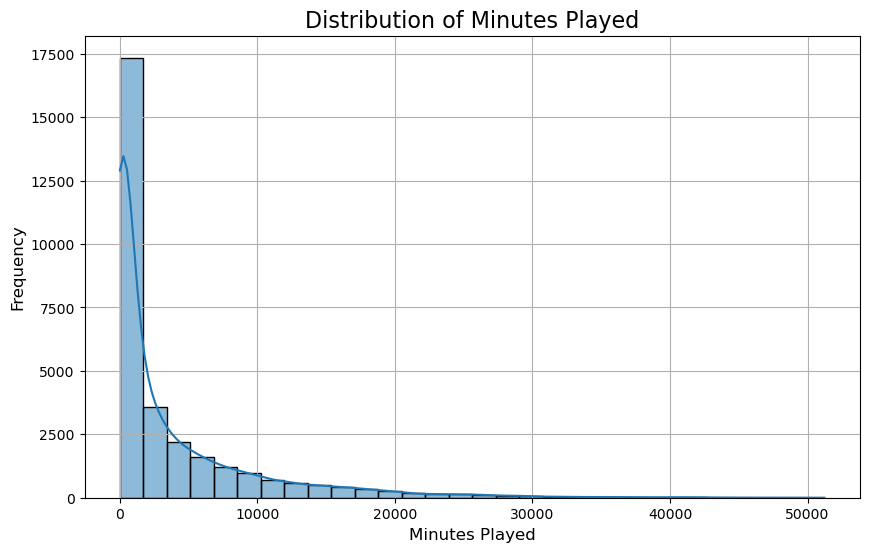

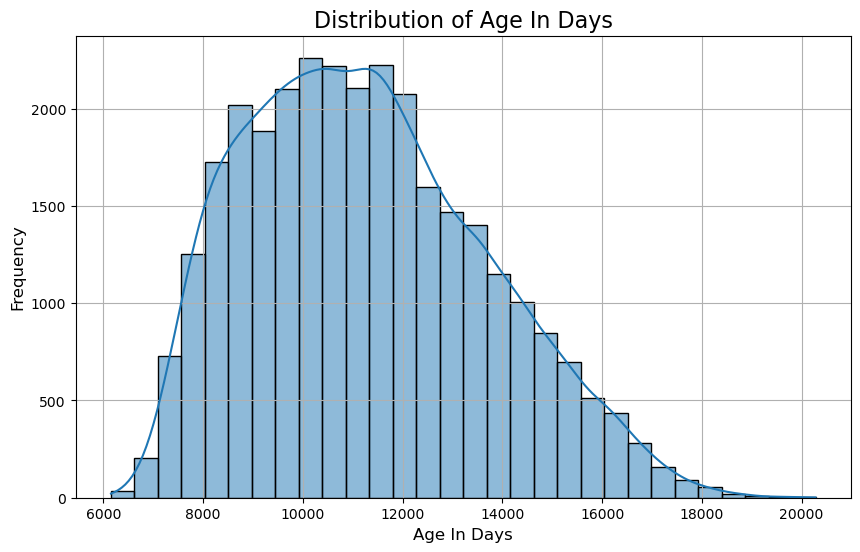

In [39]:
num_cols = [
    'height_in_cm', 'market_value_in_eur', 'contract_days_remaining', 
    'yellow_cards', 'red_cards', 'goals','assists', 'minutes_played', 
    'age_in_days'
]

cat_cols = [
    'current_club_id','country_of_birth', 'country_of_citizenship',
    'sub_position', 'position', 'foot', 'agent_name',
    'current_club_domestic_competition_id', 'current_club_name', 
    'contract_info_missing'
]

for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(players_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col.replace("_", " ").title()}', fontsize=16)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.show()

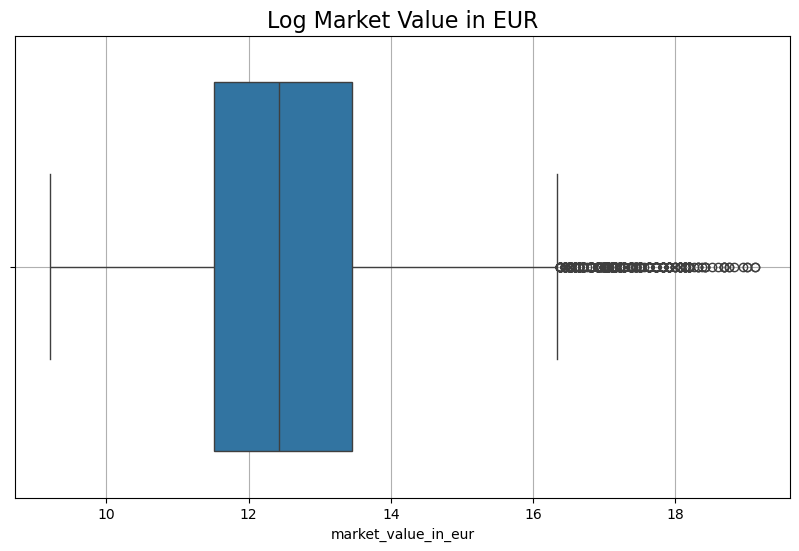

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.log1p(players_df['market_value_in_eur'])) 
plt.title('Log Market Value in EUR', fontsize=16)
plt.grid(True)
plt.show()

Log of target may be effective for models, but features relationships may be highly non-linear

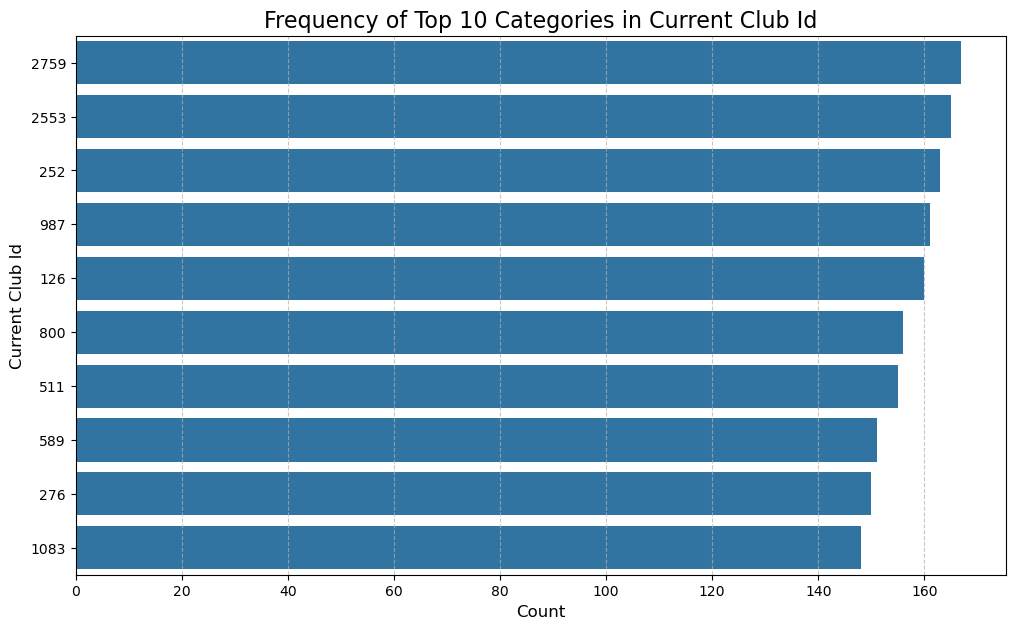

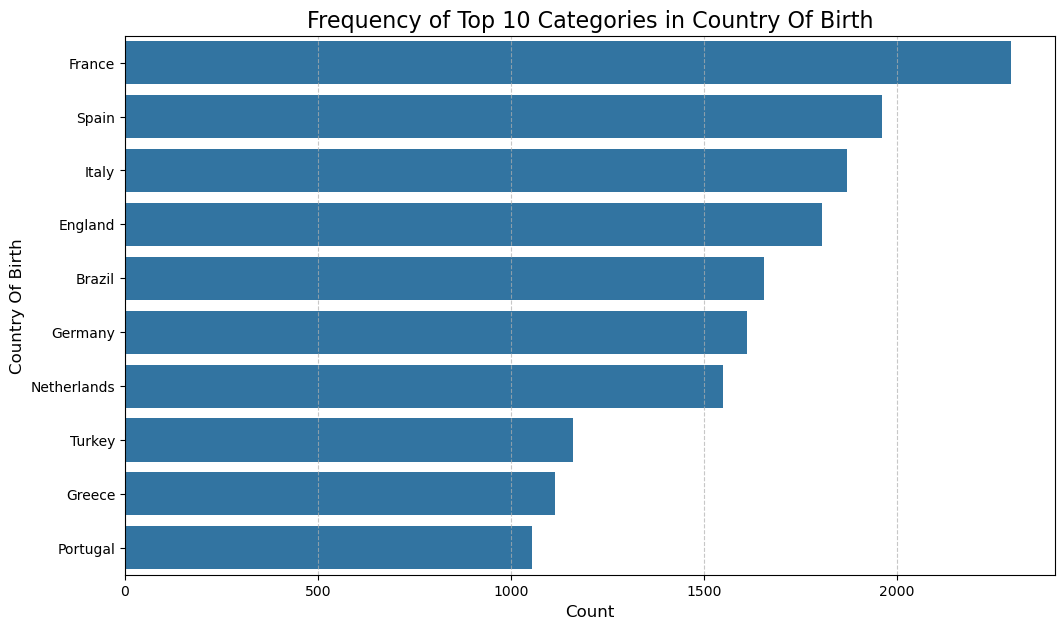

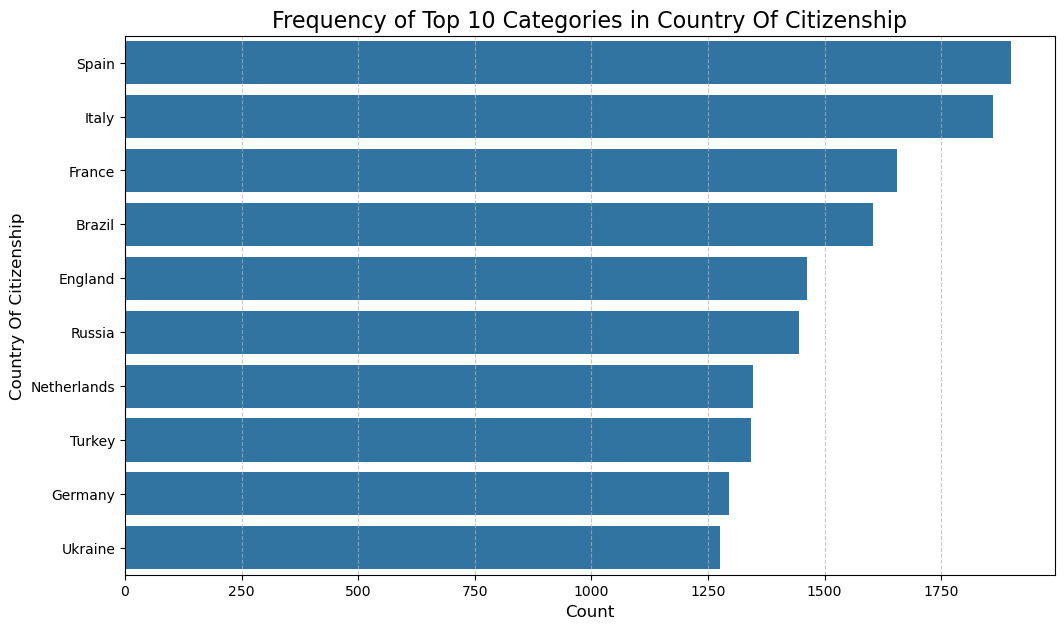

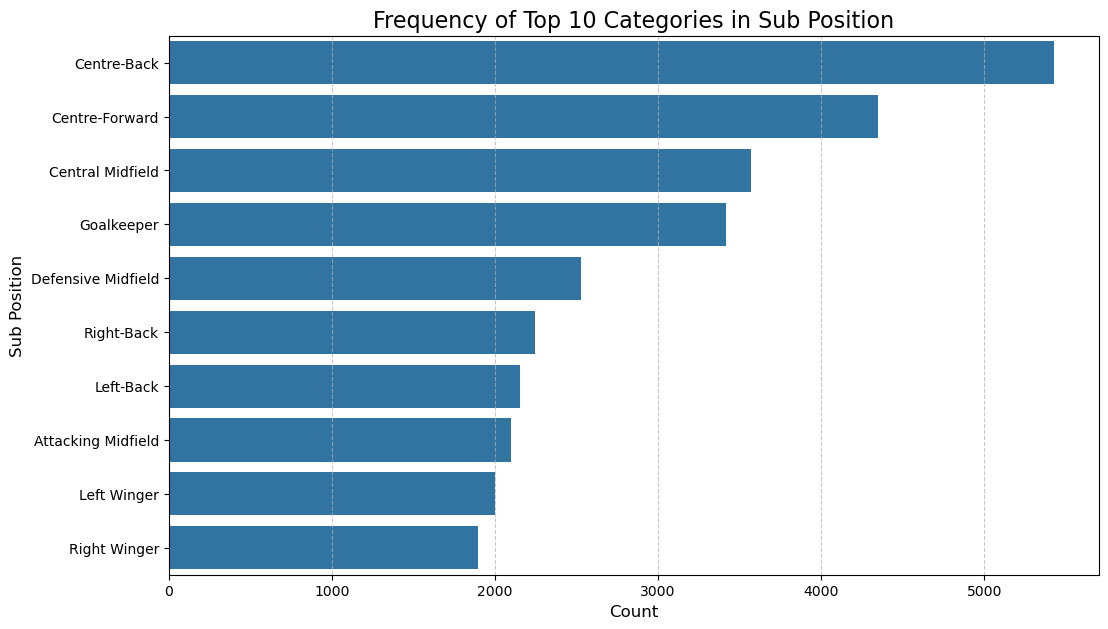

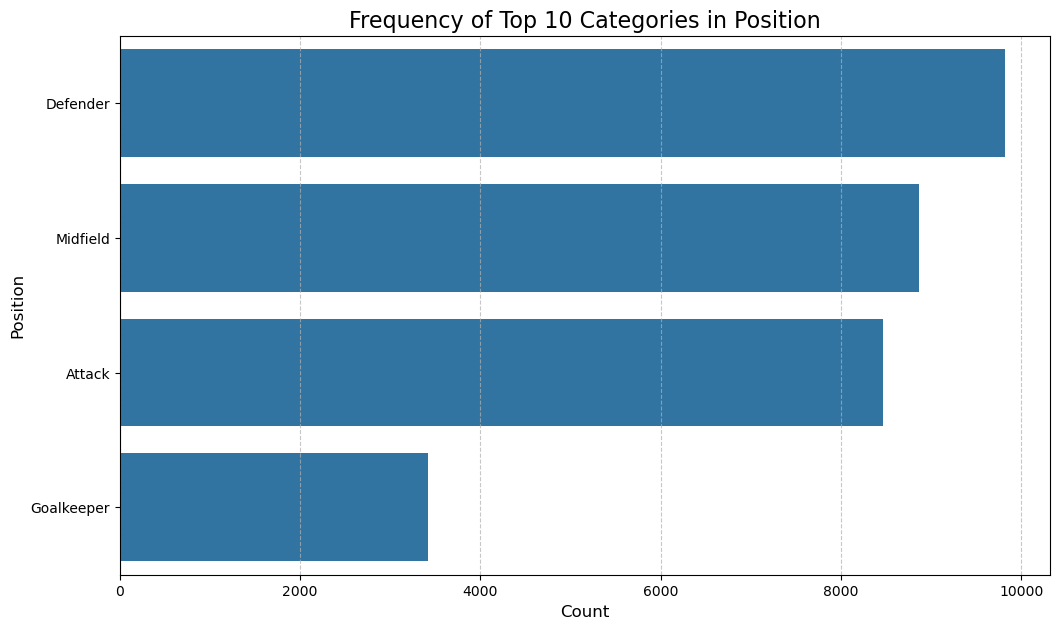

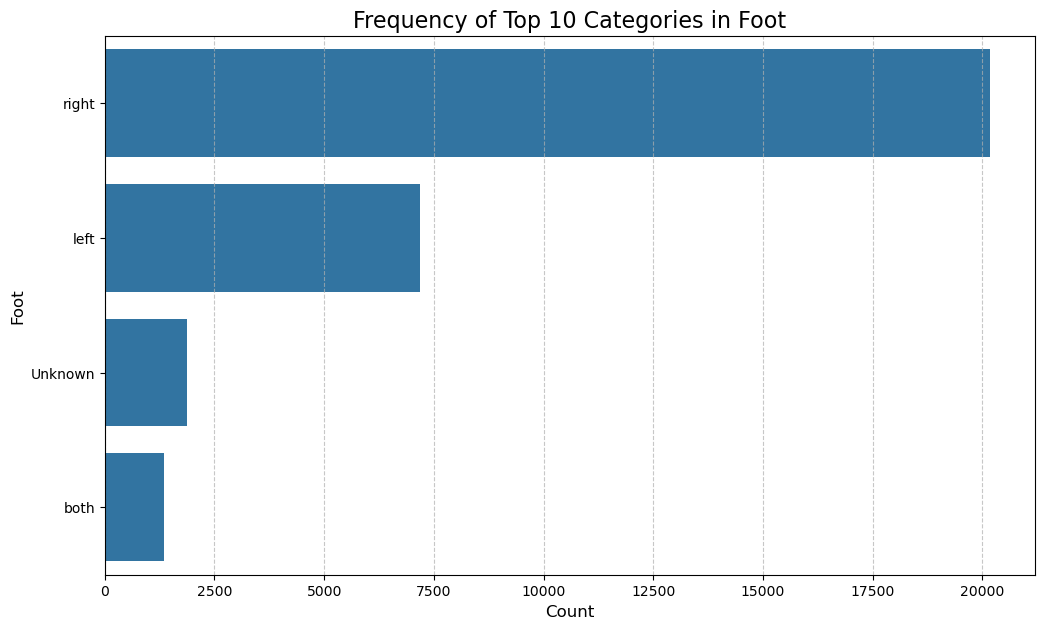

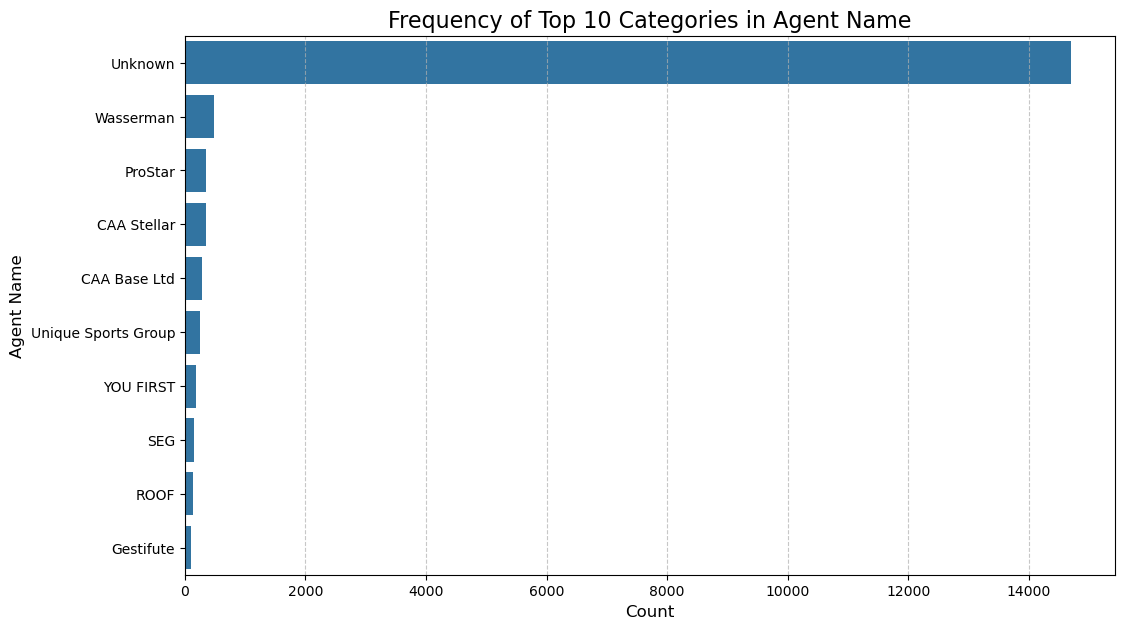

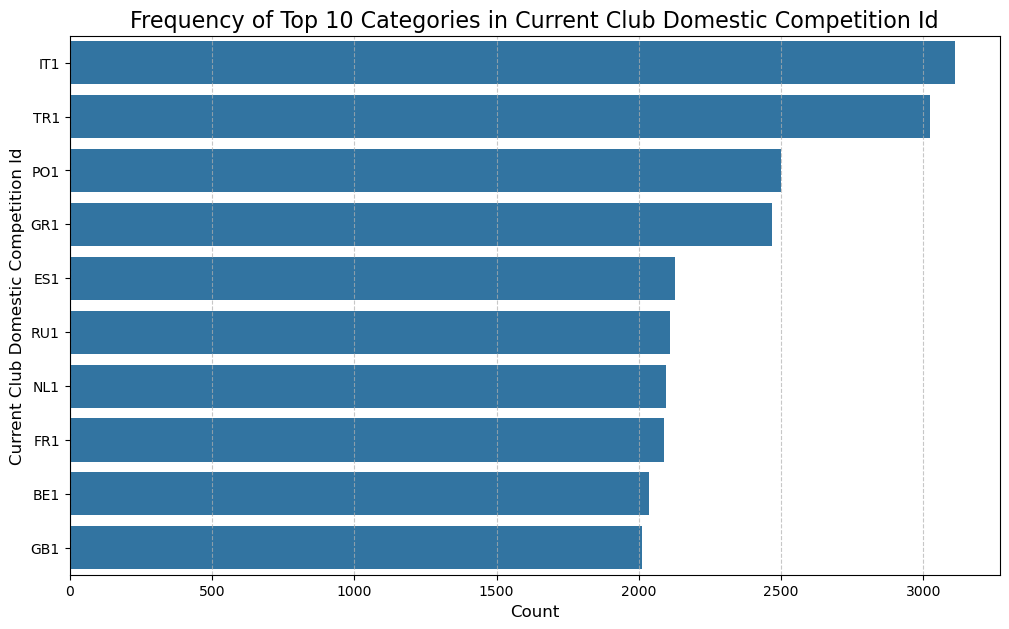

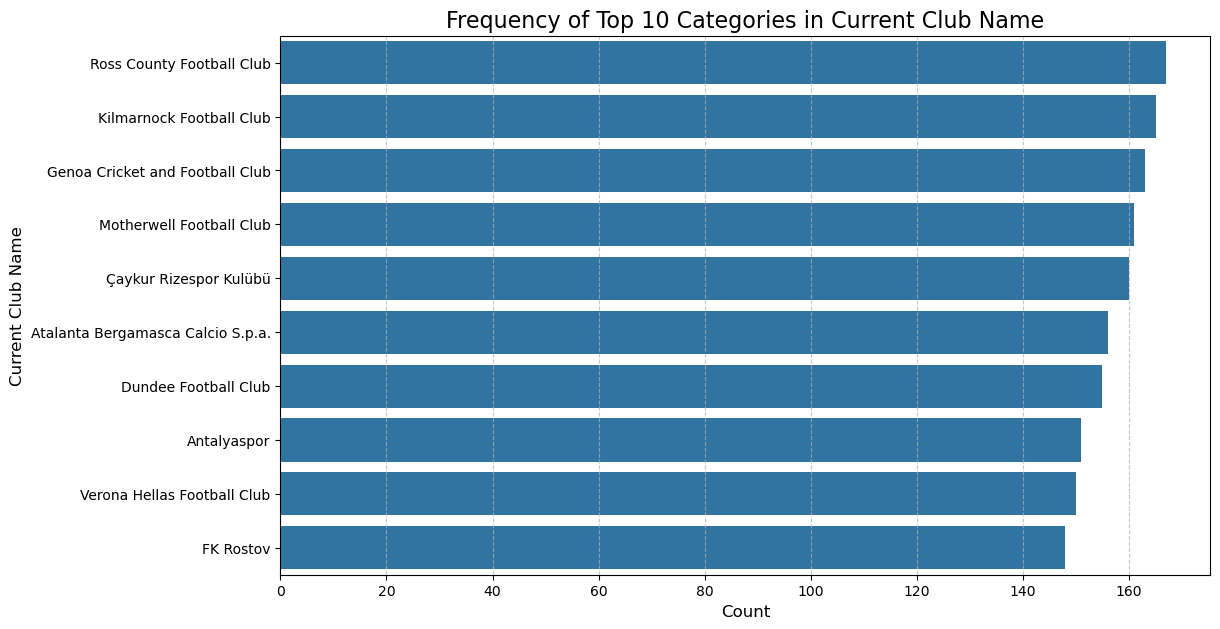

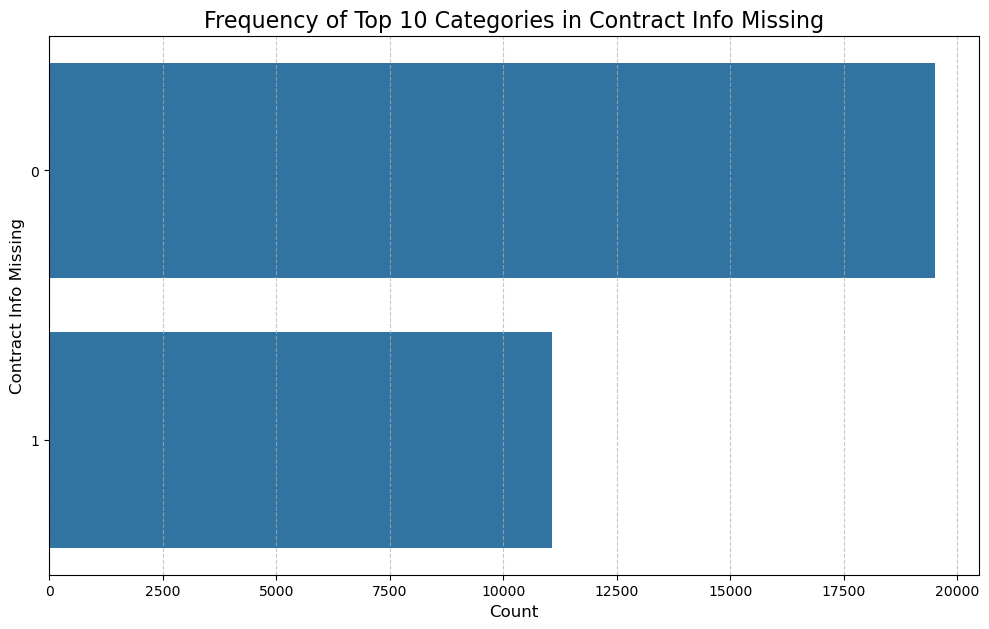

In [41]:
for col in cat_cols:

    top_categories = players_df[col].value_counts().nlargest(10).index
    
    plt.figure(figsize=(12, 7))
    sns.countplot(y=col, data=players_df, order=top_categories)
    plt.title(f'Frequency of Top 10 Categories in {col.replace("_", " ").title()}', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(col.replace("_", " ").title(), fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

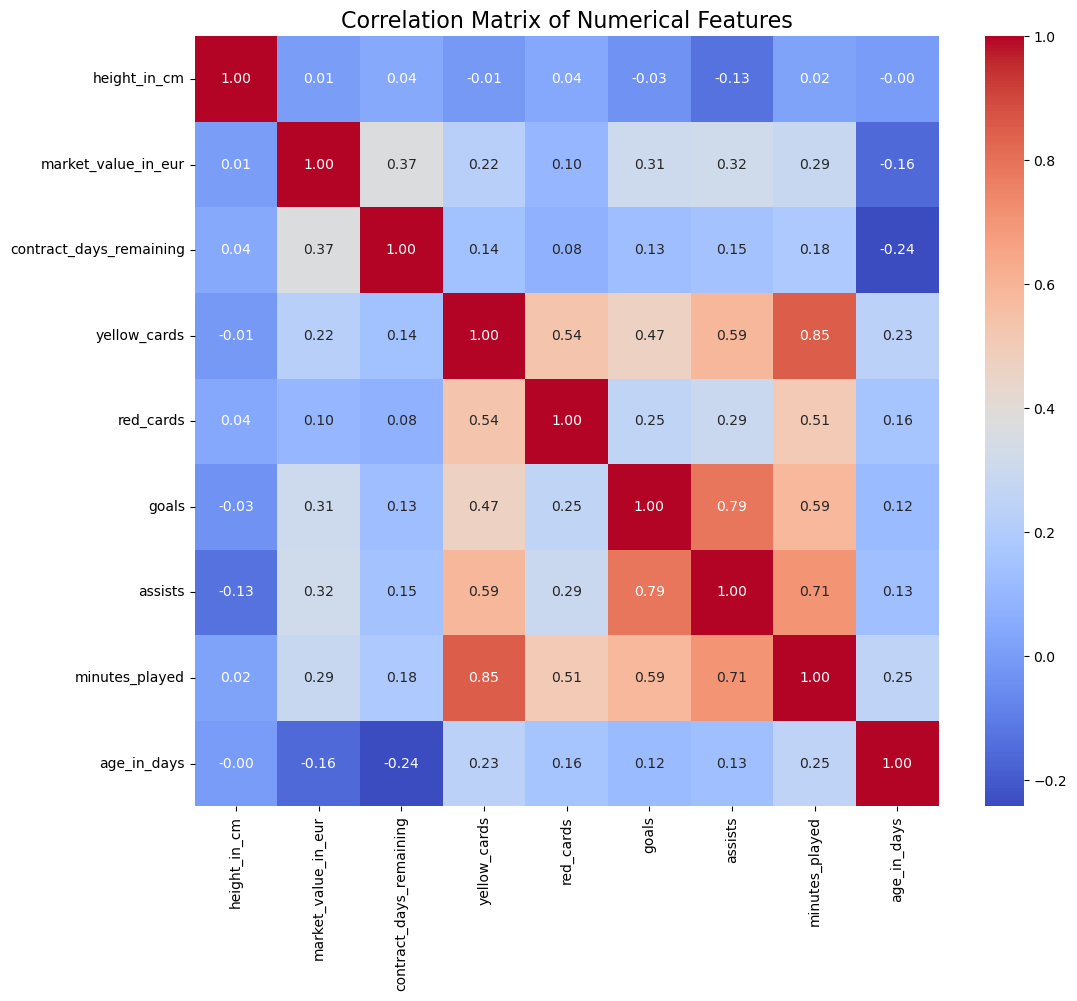

In [42]:
corr_matrix = players_df[num_cols].corr()

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix, 
    annot=True,    
    cmap='coolwarm',
    fmt=".2f"       
)

plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.show()


## Modeling

In [43]:
model_df = players_df.drop(columns=['player_id', 'name', 'last_season','current_club_id'])

In [44]:
model_df = model_df.drop(columns=['agent_name'])

In [45]:
X = model_df.drop('market_value_in_eur', axis=1)
y = model_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
def fit_evaluate_and_tune_model(X_train, X_test, y_train, y_test, model_class, num_cols, cat_cols, log_transform_target=False):
    """
    Trains, evaluates, and optionally tunes a model using pre-split data.

    Args:
        X_train, X_test, y_train, y_test: The pre-split training and testing data.
        model_class: The model class to be used.
        num_cols (list): List of numerical column names.
        cat_cols (list): List of categorical column names.
        log_transform_target (bool): If True, applies a log(1+x) transform to the target.

    Returns:
        tuple: The final (best) pipeline and its test scores (R-squared, RMSE).
    """
    
    # --- Set up a more robust warning filter ---
    warnings.filterwarnings("ignore", category=UserWarning, message=".*Found unknown categories.*")
    warnings.filterwarnings("ignore", category=FutureWarning)

    try:
        # --- 1. Initial Setup ---
        # Make copies to avoid modifying the original dataframes passed to the function
        X_train_processed = X_train.copy()
        X_test_processed = X_test.copy()
        y_train_processed = y_train.copy()
        y_test_processed = y_test.copy()

        # --- Apply Log Transform if requested ---
        if log_transform_target:
            print("\nApplying log transform to the target variable.")
            y_train_processed = np.log1p(y_train_processed)
            y_test_processed = np.log1p(y_test_processed)
        
        # --- Data Validation Step ---
        for col in num_cols:
            if col in X_train_processed.columns:
                X_train_processed[col] = pd.to_numeric(X_train_processed[col], errors='coerce')
                X_test_processed[col] = pd.to_numeric(X_test_processed[col], errors='coerce')

        # --- 2. Define Preprocessing Pipeline ---
        numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])
        
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, num_cols),
                ('cat', categorical_transformer, cat_cols)
            ],
            remainder='drop'
        )
        
        # --- 3. Evaluate Default Model ---
        default_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model_class(random_state=42) if 'random_state' in model_class().get_params() else model_class())
        ])
        
        default_pipeline.fit(X_train_processed, y_train_processed)
        y_pred_test_default = default_pipeline.predict(X_test_processed)
        y_pred_train_default = default_pipeline.predict(X_train_processed)

        # --- Inverse transform predictions if target was logged ---
        y_test_eval = np.expm1(y_test_processed) if log_transform_target else y_test_processed
        y_pred_test_eval = np.expm1(y_pred_test_default) if log_transform_target else y_pred_test_default
        y_train_eval = np.expm1(y_train_processed) if log_transform_target else y_train_processed
        y_pred_train_eval = np.expm1(y_pred_train_default) if log_transform_target else y_pred_train_default

        r2_test_default = r2_score(y_test_eval, y_pred_test_eval)
        rmse_test_default = np.sqrt(mean_squared_error(y_test_eval, y_pred_test_eval))
        r2_train_default = r2_score(y_train_eval, y_pred_train_eval)
        rmse_train_default = np.sqrt(mean_squared_error(y_train_eval, y_pred_train_eval))
        
        print(f"\n--- Initial {model_class.__name__} Evaluation ---")
        print(f"R-squared on Test Data: {r2_test_default:.2f}")
        print(f"R-squared on Training Data: {r2_train_default:.2f}")
        print(f"RMSE on Test Data: {rmse_test_default:,.2f}")
        print(f"RMSE on Training Data: {rmse_train_default:,.2f}")

        final_pipeline = default_pipeline
        final_r2 = r2_test_default
        final_rmse = rmse_test_default

        # --- 4. Conditional Hyperparameter Tuning ---
        if model_class in [RandomForestRegressor, XGBRegressor]:
            print("\n--- Starting Hyperparameter Tuning ---")
            
            # Define Model-Specific Parameter Grids
            if model_class == RandomForestRegressor:
                param_dist = {
                    'regressor__n_estimators': [100, 200, 500], 'regressor__max_depth': [10, 20, 30, None],
                    'regressor__min_samples_leaf': [1, 2, 4], 'regressor__max_features': ['sqrt', 'log2']
                }
            elif model_class == XGBRegressor:
                param_dist = {
                    'regressor__n_estimators': [100, 500, 1000], 'regressor__max_depth': [3, 5, 7, 10],
                    'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__min_child_weight': [1, 5, 10]
                }

            # Randomized Search
            random_search = RandomizedSearchCV(estimator=default_pipeline, param_distributions=param_dist, n_iter=25, cv=5, verbose=1, random_state=42, n_jobs=-2, scoring='neg_root_mean_squared_error')
            random_search.fit(X_train_processed, y_train_processed)
            print("\nBest parameters from Randomized Search:", random_search.best_params_)

            # Grid Search
            best_params = random_search.best_params_
            param_grid = {}
            for key, value in best_params.items():
                if key in ['regressor__n_estimators']:
                    step = max(100, int(value * 0.2))
                    param_grid[key] = sorted(list(set([value, max(50, value - step), value + step])))
                elif isinstance(value, int) and value > 0: # Ensure value is at least 1
                    # Ensure the lower bound is at least 1
                    lower_bound = max(1, value - 1)
                    param_grid[key] = [lower_bound, value, value + 1]
                elif isinstance(value, float):
                    lower_bound = max(0.0, value * 0.9)
                    upper_bound = min(1.0, value * 1.1)
                    param_grid[key] = [lower_bound, value, upper_bound]
                else:
                    param_grid[key] = [value]
            
            grid_search = GridSearchCV(estimator=default_pipeline, param_grid=param_grid, cv=5, verbose=1, n_jobs=-2, scoring='neg_root_mean_squared_error')
            grid_search.fit(X_train_processed, y_train_processed)
            print("\nBest parameters from Grid Search:", grid_search.best_params_)
            
            # Overwrite final results with the tuned model's performance
            final_pipeline = grid_search.best_estimator_
            y_pred_test_tuned = final_pipeline.predict(X_test_processed)
            y_pred_train_tuned = final_pipeline.predict(X_train_processed)
            
            # Inverse transform predictions if target was logged
            y_test_eval = np.expm1(y_test_processed) if log_transform_target else y_test_processed
            y_pred_test_tuned_eval = np.expm1(y_pred_test_tuned) if log_transform_target else y_pred_test_tuned
            y_train_eval = np.expm1(y_train_processed) if log_transform_target else y_train_processed
            y_pred_train_tuned_eval = np.expm1(y_pred_train_tuned) if log_transform_target else y_pred_train_tuned

            final_r2 = r2_score(y_test_eval, y_pred_test_tuned_eval)
            final_rmse = np.sqrt(mean_squared_error(y_test_eval, y_pred_test_tuned_eval))
            r2_train_tuned = r2_score(y_train_eval, y_pred_train_tuned_eval)
            rmse_train_tuned = np.sqrt(mean_squared_error(y_train_eval, y_pred_train_tuned_eval))
            
            print(f"\n--- Tuned {model_class.__name__} Evaluation ---")
            print(f"R-squared on Test Data: {final_r2:.2f}")
            print(f"R-squared on Training Data: {r2_train_tuned:.2f}")
            print(f"RMSE on Test Data: {final_rmse:,.2f}")
            print(f"RMSE on Training Data: {rmse_train_tuned:,.2f}")
            
        return final_pipeline, final_r2, final_rmse
    finally:
        warnings.resetwarnings()

# 1. Define feature lists
numerical_features = [
    'height_in_cm', 'contract_days_remaining', 'yellow_cards', 
    'red_cards', 'goals', 'assists', 'minutes_played', 'age_in_days'
]
categorical_features = [
    'country_of_birth', 'country_of_citizenship',
    'sub_position', 'position', 'foot',
    'current_club_domestic_competition_id', 'current_club_name', 
    'contract_info_missing'
]

# 2. Create the train-test split
X = model_df.drop('market_value_in_eur', axis=1)
y = model_df['market_value_in_eur']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 3. Run all experiments using the same data split
print("\n--- EXPERIMENT 1: MODELS WITH ORIGINAL TARGET ---")
lr_pipeline, lr_r2, lr_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, LinearRegression, numerical_features, categorical_features
)
rf_pipeline, rf_r2, rf_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, RandomForestRegressor, numerical_features, categorical_features
)
xgb_pipeline, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features
)


print("\n--- EXPERIMENT 2: MODELS WITH LOG-TRANSFORMED TARGET ---")
lr_pipeline_log, lr_r2_log, lr_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, LinearRegression, numerical_features, categorical_features, log_transform_target=True
)
rf_pipeline_log, rf_r2_log, rf_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, RandomForestRegressor, numerical_features, categorical_features, log_transform_target=True
)
xgb_pipeline_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- EXPERIMENT 1: MODELS WITH ORIGINAL TARGET ---

--- Initial LinearRegression Evaluation ---
R-squared on Test Data: 0.35
R-squared on Training Data: 0.38
RMSE on Test Data: 5,099,225.68
RMSE on Training Data: 5,103,652.35

--- Initial RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.64
R-squared on Training Data: 0.96
RMSE on Test Data: 3,794,145.19
RMSE on Training Data: 1,346,143.81

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Randomized Search: {'regressor__n_estimators': 500, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': None}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Grid Search: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 500}

--- Tuned RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.57
R-squared on Training Data: 0.95
RMSE on Test Data: 4,123,326.73
RMSE on Training Data: 1,486,535.28

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.97
RMSE on Test Data: 3,491,597.08
RMSE on Training Data: 1,200,141.84

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 5, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Grid Search: {'regressor__learning_rate': 0.11000000000000001, 'regressor__max_depth': 3, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.93
RMSE on Test Data: 3,542,653.10
RMSE on Training Data: 1,698,010.46

--- EXPERIMENT 2: MODELS WITH LOG-TRANSFORMED TARGET ---

Applying log transform to the target variable.

--- Initial LinearRegression Evaluation ---
R-squared on Test Data: 0.27
R-squared on Training Data: -0.01
RMSE on Test Data: 5,382,641.64
RMSE on Training Data: 6,519,661.41

Applying log transform to the target variable.

--- Initial RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.54
R-squared on Training Data: 0.90
RMSE on Test Data: 4,301,631.72
RMSE on Training Data: 2,068,382.50

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Randomized Search: {'regressor__n_estimators': 500, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 'sqrt', 'regressor__max_depth': None}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Grid Search: {'regressor__max_depth': None, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 600}

--- Tuned RandomForestRegressor Evaluation ---
R-squared on Test Data: 0.37
R-squared on Training Data: 0.80
RMSE on Test Data: 5,024,589.65
RMSE on Training Data: 2,917,714.72

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.66
R-squared on Training Data: 0.86
RMSE on Test Data: 3,703,945.76
RMSE on Training Data: 2,394,999.41

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.05}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Grid Search: {'regressor__learning_rate': 0.05500000000000001, 'regressor__max_depth': 6, 'regressor__min_child_weight': 10, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.88
RMSE on Test Data: 3,509,373.11
RMSE on Training Data: 2,213,755.13


### Target

#### --- Initial LinearRegression Evaluation ---

R-squared on Test Data: 0.35

R-squared on Training Data: 0.38

RMSE on Test Data: 5,099,226.28

RMSE on Training Data: 5,103,652.35

#### --- Tuned RandomForestRegressor Evaluation ---

R-squared on Test Data: 0.57

R-squared on Training Data: 0.95

RMSE on Test Data: 4,127,609.95

RMSE on Training Data: 1,507,199.31

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.93

RMSE on Test Data: 3,542,653.10

RMSE on Training Data: 1,698,010.46

### Log of Target

#### --- Initial LinearRegression Evaluation ---

R-squared on Test Data: 0.27

R-squared on Training Data: -0.01

RMSE on Test Data: 5,382,707.17

RMSE on Training Data: 6,519,539.32

#### --- Tuned RandomForestRegressor Evaluation ---

R-squared on Test Data: 0.37

R-squared on Training Data: 0.80

RMSE on Test Data: 5,023,226.90

RMSE on Training Data: 2,903,175.58

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.88

RMSE on Test Data: 3,509,373.11

RMSE on Training Data: 2,213,755.10

#### Key Findings

XGBoost is the Top-Performing Model: Across all experiments, the XGBoost model consistently delivered the best results on the unseen test data.

Log Transformation is Effective for XGBoost: The best overall performance was achieved by the Tuned XGBoost model using the log-transformed target. This combination yielded the highest R-squared score (0.69) and the lowest Root Mean Squared Error (€3,509,373.11).

Log Transformation Reduces Overfitting: A key insight is that the log transform improved the XGBoost model's ability to generalize. It reduced the "Performance Drop" (the gap between training and test R-squared) from 0.24 to 0.19, indicating a more robust and reliable model.

Random Forest Performance Degraded with Log Transform: Interestingly, the performance of the RandomForestRegressor was worse when using the log-transformed target (R² dropped from 0.57 to 0.37). This suggests that for this specific dataset, the Random Forest model was leveraging the original scale of the target variable in its decision trees.

Linear Regression is Not Suitable: As confirmed by the low R-squared scores in both scenarios, a LinearRegression model is not capable of capturing the complex, non-linear patterns present in this dataset.

Final Recommendation
Based on this comprehensive analysis, the final recommended model is the Tuned XGBoost Regressor trained on the log-transformed market_value_in_eur target variable.

This model provides the best balance of predictive accuracy and generalization, explaining 70% of the variance in player market value while demonstrating the least amount of overfitting among the high-performing models.

Higher profile Premier League teams would not be very interested in players below a certain market value. If we filter out players under €10M, maybe we can improve performance

In [47]:
high_val_df = model_df[model_df['market_value_in_eur'] > 10000000]

In [48]:
model_df['market_value_in_eur'].mean(), model_df['market_value_in_eur'].std()

(np.float64(1654497.9400993984), 6450610.738443693)

In [49]:
high_val_df['market_value_in_eur'].mean(), high_val_df['market_value_in_eur'].std()

(np.float64(27647540.98360656), 21616824.256933)

In [50]:
X_2 = high_val_df.drop('market_value_in_eur', axis=1)
y_2 = high_val_df['market_value_in_eur']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [51]:
xgb_pipeline2, xgb_r2, xgb_rmse2 = fit_evaluate_and_tune_model(X_train_2, X_test_2, y_train_2, y_test_2, XGBRegressor, numerical_features, categorical_features, log_transform_target=True)


Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.60
R-squared on Training Data: 0.98
RMSE on Test Data: 13,384,215.11
RMSE on Training Data: 3,006,033.19

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/


Best parameters from Randomized Search: {'regressor__n_estimators': 500, 'regressor__min_child_weight': 5, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/


Best parameters from Grid Search: {'regressor__learning_rate': 0.11000000000000001, 'regressor__max_depth': 2, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 500}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.68
R-squared on Training Data: 0.82
RMSE on Test Data: 11,870,921.39
RMSE on Training Data: 9,111,499.46


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [52]:
#New model with market values showed decreased performance

In [53]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline_log.named_steps['regressor']
preprocessor = xgb_pipeline_log.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

--- Top 15 Most Important Features (from XGBoost) ---
num__contract_days_remaining                    0.05
cat__country_of_citizenship_Turkey              0.04
cat__current_club_domestic_competition_id_GB1   0.03
cat__current_club_domestic_competition_id_L1    0.02
cat__country_of_citizenship_Ukraine             0.02
cat__current_club_domestic_competition_id_ES1   0.02
cat__current_club_domestic_competition_id_FR1   0.02
num__minutes_played                             0.02
cat__current_club_domestic_competition_id_IT1   0.02
cat__country_of_birth_Ukraine                   0.02
cat__country_of_birth_UdSSR                     0.02
cat__current_club_domestic_competition_id_DK1   0.01
cat__current_club_domestic_competition_id_TR1   0.01
cat__country_of_citizenship_Türkiye             0.01
cat__current_club_domestic_competition_id_SC1   0.01
dtype: float32


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


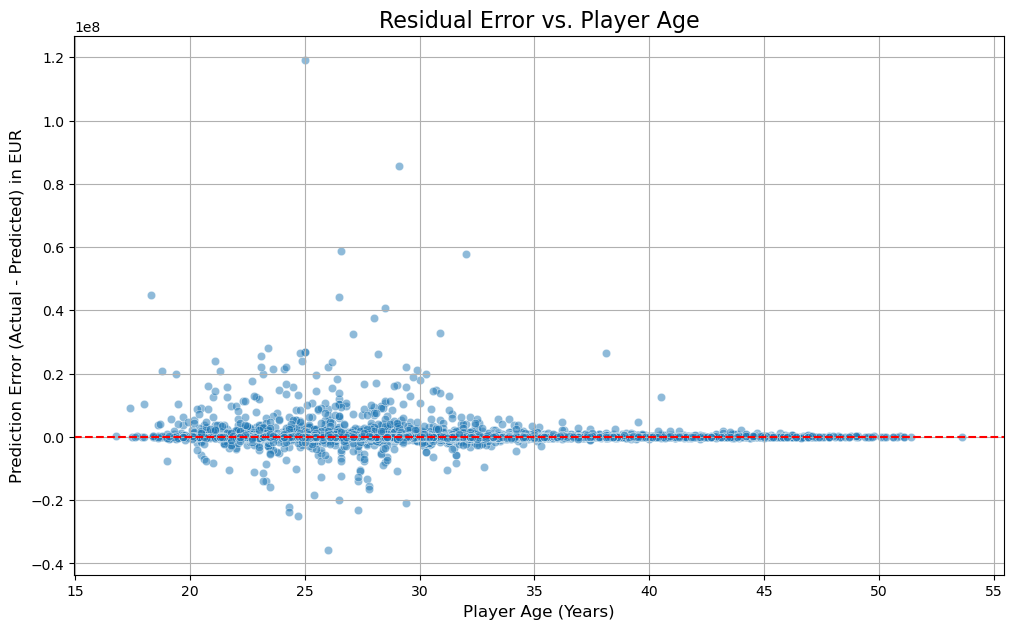

--- Top 20 Biggest Prediction Misses ---
                        name   age  actual_market_value  \
19437        Vinicius Junior 25.00       200,000,000.00   
18989                  Rodri 29.10       130,000,000.00   
20546         Victor Osimhen 26.60        70,000,000.00   
9295              Harry Kane 32.00        90,000,000.00   
29213          Ethan Nwaneri 18.30        55,000,000.00   
21144       Martín Zubimendi 26.50        60,000,000.00   
14771         Nicolò Barella 28.50        80,000,000.00   
17267          Marcus Thuram 28.00        75,000,000.00   
17466  Christoph Baumgartner 26.00        15,000,000.00   
14085        Bruno Fernandes 30.90        55,000,000.00   
22541           Eberechi Eze 27.10        55,000,000.00   
27977      Maghnes Akliouche 23.40        40,000,000.00   
20117             Marc Guéhi 25.00        45,000,000.00   
17788      Jonathan Burkardt 25.00        35,000,000.00   
2325            Lionel Messi 38.10        35,000,000.00   
23018   Giorgi 

In [54]:
# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred_log = xgb_pipeline_log.predict(X_test)

# Inverse transform predictions and actuals to their original euro scale
y_pred_eur = np.expm1(y_pred_log)
y_test_eur = y_test

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']

# Convert age back from days to years for easier interpretation
analysis_df['age'] = (analysis_df['age_in_days'] / 365.25).round(1)


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))

In [55]:
model_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,current_club_name,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,age_in_days
0,Poland,Germany,Centre-Forward,Attack,right,184.00,IT1,Società Sportiva Lazio S.p.A.,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",17214
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,L1,Borussia Dortmund,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",16425
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",16248
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,IT1,Juventus Football Club,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,17246
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,L1,FC Bayern München,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",16201


Models had solid scores but struggled with high value players, which is an important aspect for the business problem

### Additional Feature Engineering

In [79]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [80]:
clubs_df.head()

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season
0,105,sv-darmstadt-98,SV Darmstadt 98,L1,NaN,27,25.60,13,48.10,1,Merck-Stadion am Böllenfalltor,17810,+€3.05m,NaN,2023
1,11127,ural-ekaterinburg,Ural Yekaterinburg,RU1,NaN,30,26.50,11,36.70,3,Yekaterinburg Arena,23000,+€880k,NaN,2023
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,NaN,30,26.60,15,50.00,8,Beşiktaş Park,42445,€-25.26m,NaN,2024
3,12,as-rom,Associazione Sportiva Roma,IT1,NaN,26,26.30,18,69.20,17,Olimpico di Roma,70634,€-76.90m,NaN,2024
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,NaN,30,25.50,21,70.00,18,Tottenham Hotspur Stadium,62850,€-120.05m,NaN,2024


In [81]:
#Here we are getting a history of all the clubs a player has played for
# Get club names and player_ids matched
apps_df = pd.merge(
    left=appearances_df[['player_id', 'player_club_id']], 
    right=clubs_df[['club_id']], 
    left_on='player_club_id', 
    right_on='club_id', 
    how='left'
)
apps_df = apps_df[['player_id', 'player_club_id']]

# Get unique clubs for each player before counting
unique_clubs_df = apps_df.drop_duplicates(subset=['player_id', 'player_club_id']).copy()

# Adds a column that counts the unique clubs for each player (1, 2, 3, etc.)
unique_clubs_df['club_number'] = unique_clubs_df.groupby('player_id').cumcount() + 1

# Transforms the data from a long to a wide format
club_history_df = unique_clubs_df.pivot(
    index='player_id', 
    columns='club_number', 
    values='player_club_id' 
)

# Renames the numbered columns while preserving the 'player_id' index name
club_history_df.columns = [f'club_{col}' for col in club_history_df.columns]
club_history_df.reset_index(inplace=True)

# Display the head of the FINAL DataFrame
club_history_df.head()

,player_id,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13
0,10,398.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,16.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,931.00,162.00,"1,091.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77,506.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
#Merge new df with model df
model2_df = players_df.drop(columns=['name', 'last_season','current_club_id', 'current_club_name'])

model2_df = pd.merge(
    left=model2_df, 
    right=club_history_df, 
    on= 'player_id',
    how='left'
)

model2_df.head()

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,age_in_days,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13
0,10,Poland,Germany,Centre-Forward,Attack,right,184.00,ASBW Sport Marketing,IT1,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",17214,398.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,Neubauer 13 GmbH,L1,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",16425,16.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,CSKA-AS-23 Ltd.,GR1,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",16248,931.00,162.00,"1,091.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,77,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,Unknown,IT1,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,17246,506.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,80,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,IFM,L1,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",16201,27.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
#We can create a 'Age peak' metric for players centered around 27 years
# Convert age from days to years first
model2_df['age'] = model2_df['age_in_days'] / 365.25

# Create a feature that is low at the peak age (27) and higher for younger/older players
model2_df['age_peak_diff_sq'] = (model2_df['age'] - 27)**2

In [84]:
model2_df = model2_df.drop(columns=['age_in_days'])

In [85]:
#Lets create a per 90 minutes (one match) feature
model2_df['goals_per_90'] = (model2_df['goals'] * 90) / (model2_df['minutes_played'] + 1)
model2_df['assists_per_90'] = (model2_df['assists'] * 90) / (model2_df['minutes_played'] + 1)

In [86]:
club_games_df.head()

,game_id,club_id,own_goals,own_position,own_manager_name,opponent_id,opponent_goals,opponent_position,opponent_manager_name,hosting,is_win
0,2320450,"1,468.00",0.00,NaN,Holger Bachthaler,24.00,2.00,NaN,Armin Veh,Home,0
1,2320454,222.00,0.00,NaN,Volkan Uluc,79.00,2.00,NaN,Bruno Labbadia,Home,0
2,2320460,1.00,3.00,NaN,Jürgen Luginger,86.00,1.00,NaN,Robin Dutt,Home,1
3,2320472,"2,036.00",4.00,NaN,Frank Schmidt,72.00,5.00,NaN,Alexander Schmidt,Home,0
4,2321027,33.00,3.00,8.00,Jens Keller,41.00,3.00,9.00,Thorsten Fink,Home,0


In [87]:
#Instead of just club IDs or names, lets count their wins to effectively create a rating for the clubs they have played for
wins_series = club_games_df.groupby('club_id')['is_win'].sum()
wins_series = pd.Series(wins_series, name='wins')
wins_series.index.name = 'club_id'

# Convert the wins Series to a dictionary for fast lookups
wins_dict = wins_series.to_dict()

# Get the list of columns to update (e.g., 'club_1', 'club_2', ...)
club_cols = [f'club_{i}' for i in range(1, 14)]

for col in club_cols:
    # Check if the column exists in your DataFrame
    if col in model2_df.columns:
        # Use .map() to replace the club ID with its win count
        model2_df[col] = model2_df[col].map(wins_dict)

# After mapping, any clubs not in wins_dict or original NaNs will be NaN, fill these with 0.
model2_df[club_cols] = model2_df[club_cols].fillna(0).astype(int)

In [88]:
model2_df.head()

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90
0,10,Poland,Germany,Centre-Forward,Attack,right,184.00,ASBW Sport Marketing,IT1,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",324,0,0,0,0,0,0,0,0,0,0,0,0,47.13,405.19,0.49,0.26
1,26,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,Neubauer 13 GmbH,L1,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",363,0,0,0,0,0,0,0,0,0,0,0,0,44.97,322.89,0.00,0.00
2,65,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,CSKA-AS-23 Ltd.,GR1,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",93,261,348,0,0,0,0,0,0,0,0,0,0,44.48,305.71,0.39,0.13
3,77,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,Unknown,IT1,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,435,0,0,0,0,0,0,0,0,0,0,0,0,47.22,408.73,0.00,0.00
4,80,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,IFM,L1,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",490,0,0,0,0,0,0,0,0,0,0,0,0,44.36,301.23,0.00,0.00


In [89]:
appearances_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90


In [90]:
competitions_df.head()

,competition_id,name,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league
0,CIT,italy-cup,domestic_cup,75,Italy,IT1,europa,False
1,NLSC,johan-cruijff-schaal,other,122,Netherlands,NL1,europa,False
2,GRP,kypello-elladas,domestic_cup,56,Greece,GR1,europa,False
3,POSU,supertaca-candido-de-oliveira,other,136,Portugal,PO1,europa,False
4,RUSS,russian-super-cup,other,141,Russia,RU1,europa,False


In [91]:
games_df.head()

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,away_club_position,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type
0,2321027,L1,2013,1. Matchday,2013-08-11,33.00,41.00,3.00,3.00,8.00,9.00,Jens Keller,Thorsten Fink,Veltins-Arena,"61,973.00",Manuel Gräfe,https://www.transfermarkt.co.uk/fc-schalke-04_...,4-2-3-1,4-2-3-1,FC Schalke 04,Hamburger SV,3:3,domestic_league
1,2321033,L1,2013,1. Matchday,2013-08-10,23.00,86.00,0.00,1.00,13.00,7.00,Torsten Lieberknecht,Robin Dutt,EINTRACHT-Stadion,"23,000.00",Deniz Aytekin,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-3-1-2,Eintracht Braunschweig,Sportverein Werder Bremen von 1899,0:1,domestic_league
2,2321044,L1,2013,2. Matchday,2013-08-18,16.00,23.00,2.00,1.00,1.00,15.00,Jürgen Klopp,Torsten Lieberknecht,SIGNAL IDUNA PARK,"80,200.00",Peter Sippel,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,4-3-2-1,Borussia Dortmund,Eintracht Braunschweig,2:1,domestic_league
3,2321060,L1,2013,3. Matchday,2013-08-25,23.00,24.00,0.00,2.00,18.00,11.00,Torsten Lieberknecht,Armin Veh,EINTRACHT-Stadion,"23,325.00",Wolfgang Stark,https://www.transfermarkt.co.uk/eintracht-brau...,4-3-2-1,4-2-3-1,Eintracht Braunschweig,Eintracht Frankfurt Fußball AG,0:2,domestic_league
4,2321072,L1,2013,5. Matchday,2013-09-14,16.00,41.00,6.00,2.00,1.00,15.00,Jürgen Klopp,Thorsten Fink,SIGNAL IDUNA PARK,"80,645.00",Tobias Welz,https://www.transfermarkt.co.uk/borussia-dortm...,4-2-3-1,3-5-2,Borussia Dortmund,Hamburger SV,6:2,domestic_league


In [92]:
#We want to adjust the goals, assists, and minutes for players based on who they played against, i.e. weigh them based off the 'toughness' of the competition
stats_df = pd.merge(
    left=appearances_df, 
    right=games_df[['game_id', 'home_club_id', 'away_club_id']],
    on='game_id',
    how='left'
)
stats_df.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played,home_club_id,away_club_id
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90,853.00,"10,747.00"
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90,"8,841.00","22,783.00"
2,2234413_42792,2234413,42792,6251,465,2012-07-05,Sander Puri,ELQ,0,0,0,0,45,"6,251.00","11,915.00"
3,2234418_73333,2234418,73333,1274,6646,2012-07-05,Vegar Hedenstad,ELQ,0,0,0,0,90,"3,779.00","1,274.00"
4,2234421_122011,2234421,122011,195,3008,2012-07-05,Markus Henriksen,ELQ,0,0,0,1,90,"21,532.00",195.00


In [93]:
#Keep the opponent id
stats_df['Opp'] = np.where(
    stats_df['player_club_id'] == stats_df['home_club_id'],  # Condition
    stats_df['away_club_id'],                               # Value if True
    stats_df['home_club_id']                                # Value if False
)

In [94]:
stats_df = stats_df.drop(columns=['appearance_id', 'game_id', 'player_current_club_id', 'date', 'player_name', 'yellow_cards', 'red_cards', 'home_club_id', 'away_club_id'])

In [95]:
wins_df = wins_series.reset_index()

In [97]:
#Normalize wins before adjusting goals, etc
norm_scaler = MinMaxScaler()
wins_df['normal_wins'] = norm_scaler.fit_transform(wins_df[['wins']])

In [98]:
wins_df.head()

,club_id,wins,normal_wins
0,1.00,10,0.02
1,2.00,16,0.03
2,3.00,109,0.22
3,4.00,34,0.07
4,5.00,311,0.62


In [99]:
#Merge on previous df
stats_df = pd.merge(
    left=stats_df, 
    right=wins_df[['club_id', 'normal_wins']],
    left_on='Opp',
    right_on='club_id',
    how='left'
)

In [100]:
#Create new cols for adjusted stats
cols = ['goals', 'assists', 'minutes_played']

for col in cols:
    stats_df[f'{col}_adjusted'] = stats_df['normal_wins'] * stats_df[col]

In [101]:
#Group before adding back to main df
weighted_stats = stats_df.groupby('player_id')[['normal_wins', 'goals_adjusted', 'assists_adjusted', 'minutes_played_adjusted']].sum()

In [102]:
weighted_stats = weighted_stats.reset_index()

In [103]:
weighted_stats

,player_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,10,56.88,15.65,8.11,"3,819.76"
1,26,66.87,0.00,0.00,"5,924.87"
2,65,45.39,11.33,5.23,"3,224.13"
3,77,1.58,0.00,0.00,135.87
4,80,3.61,0.00,0.00,324.86
...,...,...,...,...,...
25681,1310513,0.89,0.00,0.00,4.09
25682,1358447,0.31,0.00,0.00,0.93
25683,1375876,0.85,0.00,0.00,3.59
25684,1378362,0.19,0.00,0.00,5.16


In [104]:
model2_df = pd.merge(
    left=model2_df, 
    right=weighted_stats,
    on='player_id',
    how='left'
)

In [105]:
model2_df.sort_values('goals_adjusted', ascending=False).head()

,player_id,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,agent_name,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
3223,38253,Poland,Poland,Centre-Forward,Attack,right,185.00,Gol International,ES1,"15,000,000.00",338.00,0,59.00,1.00,507.00,118.00,"51,228.00",363,490,502,0,0,0,0,0,0,0,0,0,0,36.93,98.57,0.89,0.21,264.07,201.34,47.87,"22,247.35"
747,8198,Portugal,Portugal,Centre-Forward,Attack,right,187.00,Gestifute,GB1,"15,000,000.00",-27.00,0,64.00,4.00,432.00,114.00,"41,150.00",502,435,370,0,0,0,0,0,0,0,0,0,0,40.47,181.39,0.94,0.25,222.05,188.98,41.15,"18,945.01"
2325,28003,Argentina,Argentina,Right Winger,Attack,left,170.00,Unknown,FR1,"35,000,000.00",-27.00,1,49.00,1.00,451.00,224.00,"44,380.00",502,419,0,0,0,0,0,0,0,0,0,0,0,38.09,122.97,0.91,0.45,244.46,187.98,88.65,"20,756.91"
9295,132098,England,England,Centre-Forward,Attack,right,188.00,CK66,L1,"90,000,000.00",703.00,0,52.00,0.00,346.00,85.00,"39,942.00",345,48,490,0,0,0,0,0,0,0,0,0,0,31.99,24.95,0.78,0.19,198.25,120.68,34.78,"16,484.75"
9920,148455,Egypt,Egypt,Right Winger,Attack,left,175.00,Unknown,GB1,"55,000,000.00",-27.00,0,20.00,0.00,292.00,144.00,"41,706.00",65,387,278,341,403,0,0,0,0,0,0,0,0,33.11,37.35,0.63,0.31,230.88,119.87,58.58,"18,489.07"


In [106]:
#Realized way down that I needed a copy for future use
model5_df = model2_df.copy()

#Drop unneeded cols
model2_df = model2_df.drop(columns=['player_id', 'agent_name'])

In [107]:
model2_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,Poland,Germany,Centre-Forward,Attack,right,184.00,IT1,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",324,0,0,0,0,0,0,0,0,0,0,0,0,47.13,405.19,0.49,0.26,56.88,15.65,8.11,"3,819.76"
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,L1,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",363,0,0,0,0,0,0,0,0,0,0,0,0,44.97,322.89,0.00,0.00,66.87,0.00,0.00,"5,924.87"
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,GR1,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",93,261,348,0,0,0,0,0,0,0,0,0,0,44.48,305.71,0.39,0.13,45.39,11.33,5.23,"3,224.13"
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,IT1,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,435,0,0,0,0,0,0,0,0,0,0,0,0,47.22,408.73,0.00,0.00,1.58,0.00,0.00,135.87
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,L1,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",490,0,0,0,0,0,0,0,0,0,0,0,0,44.36,301.23,0.00,0.00,3.61,0.00,0.00,324.86


In [108]:
model2_df.columns

Index(['country_of_birth', 'country_of_citizenship', 'sub_position',
       'position', 'foot', 'height_in_cm',
       'current_club_domestic_competition_id', 'market_value_in_eur',
       'contract_days_remaining', 'contract_info_missing', 'yellow_cards',
       'red_cards', 'goals', 'assists', 'minutes_played', 'club_1', 'club_2',
       'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 'club_8', 'club_9',
       'club_10', 'club_11', 'club_12', 'club_13', 'age', 'age_peak_diff_sq',
       'goals_per_90', 'assists_per_90', 'normal_wins', 'goals_adjusted',
       'assists_adjusted', 'minutes_played_adjusted'],
      dtype='object')

In [109]:
numerical_features = ['height_in_cm', 'contract_days_remaining', 'yellow_cards',
                      'goals', 'assists', 'minutes_played', 'red_cards', 'club_1', 
                      'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 
                      'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 
                      'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90', 
                      'assists_per_90','goals_adjusted', 'assists_adjusted', 
                      'minutes_played_adjusted'
                     ]

categorical_features = ['country_of_birth', 'country_of_citizenship', 'sub_position', 
                        'position', 'foot', 'current_club_domestic_competition_id',
                        'contract_info_missing'
                       ]
                        
X = model2_df.drop('market_value_in_eur', axis=1)
y = model2_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline3, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=False
)

xgb_pipeline3_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.98
RMSE on Test Data: 3,507,755.16
RMSE on Training Data: 950,053.72

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x103829bc0>
Traceback (most re


Best parameters from Grid Search: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 11, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.69
R-squared on Training Data: 0.94
RMSE on Test Data: 3,501,887.67
RMSE on Training Data: 1,536,360.51

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.65
R-squared on Training Data: 0.89
RMSE on Test Data: 3,718,114.08
RMSE on Training Data: 2,178,794.30

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.05}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Grid Search: {'regressor__learning_rate': 0.045000000000000005, 'regressor__max_depth': 6, 'regressor__min_child_weight': 11, 'regressor__n_estimators': 800}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.71
R-squared on Training Data: 0.89
RMSE on Test Data: 3,418,576.59
RMSE on Training Data: 2,142,353.22


## ---- Former Model ----

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.93

RMSE on Test Data: 3,542,653.10

RMSE on Training Data: 1,698,010.46

#### --- Tuned XGBRegressor Evaluation (Log) ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.88

RMSE on Test Data: 3,509,373.11

RMSE on Training Data: 2,213,755.10

## ---- New Model ----

#### --- Tuned XGBRegressor Evaluation ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.95

RMSE on Test Data: 3,506,685.04

RMSE on Training Data: 1,519,024.95

#### --- Tuned XGBRegressor Evaluation (Log) ---

R-squared on Test Data: 0.69

R-squared on Training Data: 0.90

RMSE on Test Data: 3,501,733.18

RMSE on Training Data: 2,071,491.77

Extremely marginal improvement on RMSE and R-squared is basically the same, generalizes worse

--- Top 15 Most Important Features (from XGBoost) ---
num__contract_days_remaining                    0.12
cat__current_club_domestic_competition_id_GB1   0.05
cat__country_of_citizenship_Turkey              0.05
num__minutes_played_adjusted                    0.04
cat__country_of_citizenship_Ukraine             0.03
cat__country_of_birth_UdSSR                     0.03
cat__current_club_domestic_competition_id_FR1   0.03
cat__current_club_domestic_competition_id_L1    0.03
num__minutes_played                             0.02
cat__contract_info_missing_1                    0.02
cat__current_club_domestic_competition_id_ES1   0.02
num__goals_adjusted                             0.02
num__assists_adjusted                           0.02
cat__current_club_domestic_competition_id_TR1   0.02
cat__current_club_domestic_competition_id_IT1   0.02
dtype: float32


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


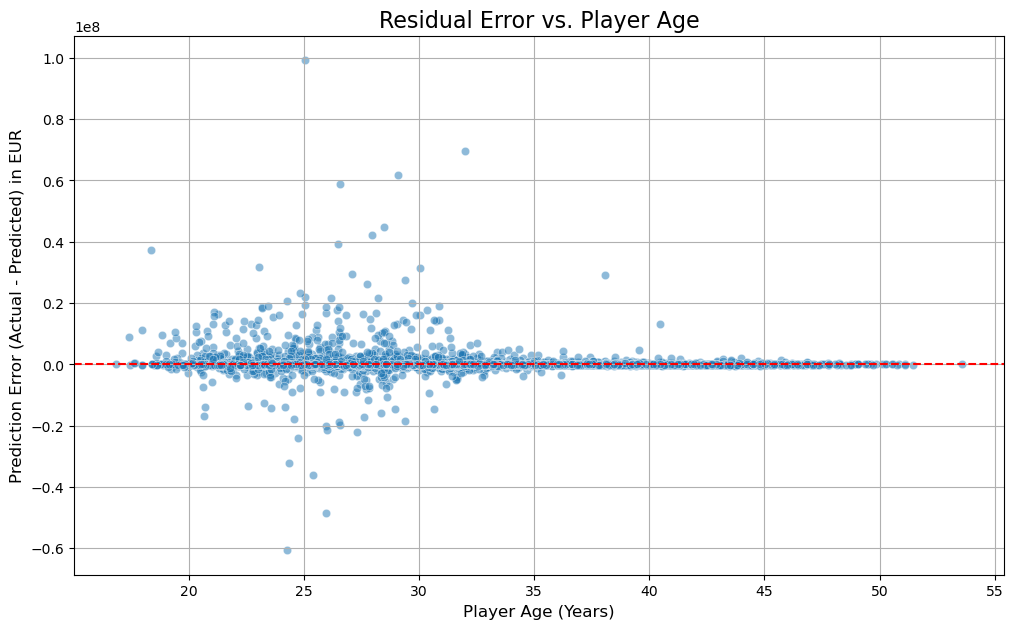

--- Top 20 Biggest Prediction Misses ---
                       name   age  actual_market_value  \
19437       Vinicius Junior 25.04       200,000,000.00   
9295             Harry Kane 31.99        90,000,000.00   
18989                 Rodri 29.09       130,000,000.00   
24231      Santiago Gimenez 24.27        37,000,000.00   
20546        Victor Osimhen 26.57        70,000,000.00   
17536      Matthijs de Ligt 25.95        40,000,000.00   
14771        Nicolò Barella 28.46        80,000,000.00   
17267         Marcus Thuram 27.97        75,000,000.00   
21144      Martín Zubimendi 26.48        60,000,000.00   
29213         Ethan Nwaneri 18.35        55,000,000.00   
20406         Ferran Torres 25.40        28,000,000.00   
22166     Benoît Badiashile 24.33        25,000,000.00   
30043               Murillo 23.06        55,000,000.00   
14854         João Palhinha 30.05        40,000,000.00   
22541          Eberechi Eze 27.07        55,000,000.00   
2325           Lionel Messi 38.

In [110]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline3_log.named_steps['regressor']
preprocessor = xgb_pipeline3_log.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred_log = xgb_pipeline3_log.predict(X_test)

# Inverse transform predictions and actuals to their original euro scale
y_pred_eur = np.expm1(y_pred_log)
y_test_eur = y_test

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))

In [111]:
model2_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,Poland,Germany,Centre-Forward,Attack,right,184.00,IT1,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",324,0,0,0,0,0,0,0,0,0,0,0,0,47.13,405.19,0.49,0.26,56.88,15.65,8.11,"3,819.76"
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,L1,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",363,0,0,0,0,0,0,0,0,0,0,0,0,44.97,322.89,0.00,0.00,66.87,0.00,0.00,"5,924.87"
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,GR1,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",93,261,348,0,0,0,0,0,0,0,0,0,0,44.48,305.71,0.39,0.13,45.39,11.33,5.23,"3,224.13"
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,IT1,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,435,0,0,0,0,0,0,0,0,0,0,0,0,47.22,408.73,0.00,0.00,1.58,0.00,0.00,135.87
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,L1,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",490,0,0,0,0,0,0,0,0,0,0,0,0,44.36,301.23,0.00,0.00,3.61,0.00,0.00,324.86


In [112]:
#Country of citizenship and birth were some big indicators, but objectively they should not effect true player value, lets try taking them out
model3_df = model2_df.drop(columns=['country_of_birth', 'country_of_citizenship'])

In [113]:
numerical_features = ['height_in_cm', 'contract_days_remaining', 'yellow_cards',
                      'goals', 'assists', 'minutes_played', 'red_cards', 'club_1', 
                      'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 
                      'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 
                      'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90', 
                      'assists_per_90','goals_adjusted', 'assists_adjusted', 
                      'minutes_played_adjusted'
                     ]

categorical_features = ['sub_position', 'position', 'foot', 
                        'current_club_domestic_competition_id','contract_info_missing'
                       ]
                        
X = model3_df.drop('market_value_in_eur', axis=1)
y = model3_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline4, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=False
)

xgb_pipeline4_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.71
R-squared on Training Data: 0.98
RMSE on Test Data: 3,426,702.14
RMSE on Training Data: 856,221.45

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x106039bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
Exception ignored in: <function ResourceTracker.__del__ at 0x1055e9bc0>
Trace


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
Exception ignored in: <function ResourceTracker.__del__ at 0x10294dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x103aa5bc0>
Trace


Best parameters from Grid Search: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__min_child_weight': 11, 'regressor__n_estimators': 1200}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.68
R-squared on Training Data: 0.95
RMSE on Test Data: 3,557,166.22
RMSE on Training Data: 1,501,559.87

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.64
R-squared on Training Data: 0.92
RMSE on Test Data: 3,811,703.11
RMSE on Training Data: 1,862,323.98

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


Exception ignored in: <function ResourceTracker.__del__ at 0x104f39bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
Exception ignored in: <function ResourceTracker.__del__ at 0x1071f9bc0>
Trace


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
Exception ignored in: <function ResourceTracker.__del__ at 0x107211bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x1038c9bc0>
Trace


Best parameters from Grid Search: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 4, 'regressor__min_child_weight': 9, 'regressor__n_estimators': 800}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.68
R-squared on Training Data: 0.88
RMSE on Test Data: 3,547,991.67
RMSE on Training Data: 2,212,914.56


Dropping was not effective and decreased performance

In [182]:
#Here I want to try further enhancing our weighed stats. The opponent faced is important, but let's also measure the quality of 
#competition (tournament) that they are in.
stats_df.head()

,player_id,player_club_id,competition_id,goals,assists,minutes_played,Opp,club_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted,normal_score
0,38004,853,CLQ,2,0,90,"10,747.00","10,747.00",0.00,0.00,0.00,0.09,0.53
1,79232,8841,ELQ,0,0,90,"22,783.00","22,783.00",0.02,0.00,0.00,0.78,0.43
2,42792,6251,ELQ,0,0,45,"11,915.00","11,915.00",0.00,0.00,0.00,0.00,0.43
3,73333,1274,ELQ,0,0,90,"3,779.00","3,779.00",0.00,0.00,0.00,0.16,0.43
4,122011,195,ELQ,0,1,90,"21,532.00","21,532.00",0.02,0.00,0.01,0.70,0.43


In [115]:
competitions_df.head()

,competition_id,name,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league
0,CIT,italy-cup,domestic_cup,75,Italy,IT1,europa,False
1,NLSC,johan-cruijff-schaal,other,122,Netherlands,NL1,europa,False
2,GRP,kypello-elladas,domestic_cup,56,Greece,GR1,europa,False
3,POSU,supertaca-candido-de-oliveira,other,136,Portugal,PO1,europa,False
4,RUSS,russian-super-cup,other,141,Russia,RU1,europa,False


In [116]:
competitions_df['country_name'].unique()

array(['Italy', 'Netherlands', 'Greece', 'Portugal', 'Russia', 'Spain',
       nan, 'Denmark', 'France', 'Belgium', 'England', 'Ukraine',
       'Turkey', 'Germany', 'Scotland'], dtype=object)

In [117]:
competitions_df['type'].unique()

array(['domestic_cup', 'other', 'international_cup', 'domestic_league'],
      dtype=object)

In [118]:
competitions_df[competitions_df['type'] == 'other']

,competition_id,name,type,country_id,country_name,domestic_league_code,confederation,is_major_national_league
1,NLSC,johan-cruijff-schaal,other,122,Netherlands,NL1,europa,False
3,POSU,supertaca-candido-de-oliveira,other,136,Portugal,PO1,europa,False
4,RUSS,russian-super-cup,other,141,Russia,RU1,europa,False
5,SUC,supercopa,other,157,Spain,ES1,europa,False
15,BESC,belgian-supercup,other,19,Belgium,BE1,europa,False
19,CGB,efl-cup,other,189,England,GB1,europa,False
24,UKRS,ukrainian-super-cup,other,177,Ukraine,UKR1,europa,False
31,GBCS,community-shield,other,189,England,GB1,europa,False
32,KLUB,fifa-klub-wm,other,-1,NaN,NaN,europa,False
36,SCI,supercoppa-italiana,other,75,Italy,IT1,europa,False


In [119]:
competitions_df[competitions_df['type'] == 'international_cup']['name']

6                                  uefa-super-cup
8                                   europa-league
17                         uefa-conference-league
18                    europa-league-qualifikation
21    uefa-europa-conference-league-qualifikation
27                          uefa-champions-league
38            uefa-champions-league-qualifikation
Name: name, dtype: object

In [120]:
#Map by country (coefficient score from UEFA)
country_value_map = {
    'England': 90.839,
    'Spain': 74.953,
    'Germany': 71.117,
    'Italy': 80.946,
    'France': 65.177,
    'Portugal': 52.766,
    'Netherlands': 58.116,
    'Belgium': 51.150,
    'Turkey': 41,
    'Russia': 18.299,
    'Greece': 34.412,
    'Ukraine': 18.475,
    'Denmark': 30.481,
    'Scotland': 26.125
}

competitions_df['country_score'] = competitions_df['country_name'].map(country_value_map)

In [121]:
#My own weights based off domain knowledge, relative to country score
int_map =  {
    'uefa-super-cup': 75,
    'europa-league': 80,
    'uefa-conference-league': 65,
    'europa-league-qualifikation': 55,
    'uefa-europa-conference-league-qualifikation': 45,
    'uefa-champions-league': 115,
    'uefa-champions-league-qualifikation': 65
}

competitions_df['int_score'] = competitions_df['name'].map(int_map)

# Define list of conditions
conditions = [
    competitions_df['type'] == 'domestic_cup',
    competitions_df['type'] == 'domestic_league',
    competitions_df['type'] == 'other',
    competitions_df['type'] == 'international_cup'
]

# Define the list of choices that correspond to each condition
choices = [
    competitions_df['country_score'] * 0.75,
    competitions_df['country_score'],
    competitions_df['country_score'] * 0.5,
    competitions_df['int_score']
]

# 3. Create the new column using np.select
# The 'default' value is used if none of the conditions are met.
competitions_df['comp_score'] = np.select(conditions, choices, default=0)

In [122]:
#Fix KLUB competition
competitions_df['comp_score'] = competitions_df['comp_score'].fillna(55)

In [123]:
competitions_df[['name', 'comp_score']].sort_values('comp_score',ascending=False)

,name,comp_score
27,uefa-champions-league,115.00
16,premier-league,90.84
11,serie-a,80.95
8,europa-league,80.00
6,uefa-super-cup,75.00
9,laliga,74.95
33,bundesliga,71.12
22,fa-cup,68.13
10,ligue-1,65.18
38,uefa-champions-league-qualifikation,65.00


In [124]:
#Normalize comp_score before adjusting goals, etc
competitions_df['normal_score'] = norm_scaler.fit_transform(competitions_df[['comp_score']])

In [125]:
stats_df = pd.merge(
    left=stats_df, 
    right=competitions_df[['normal_score', 'competition_id']],
    on='competition_id',
    how='left'
)

In [126]:
stats_df.head()

,player_id,player_club_id,competition_id,goals,assists,minutes_played,Opp,club_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted,normal_score
0,38004,853,CLQ,2,0,90,"10,747.00","10,747.00",0.00,0.00,0.00,0.18,0.53
1,79232,8841,ELQ,0,0,90,"22,783.00","22,783.00",0.02,0.00,0.00,1.79,0.43
2,42792,6251,ELQ,0,0,45,"11,915.00","11,915.00",0.00,0.00,0.00,0.00,0.43
3,73333,1274,ELQ,0,0,90,"3,779.00","3,779.00",0.00,0.00,0.00,0.36,0.43
4,122011,195,ELQ,0,1,90,"21,532.00","21,532.00",0.02,0.00,0.02,1.61,0.43


In [127]:
# List of the already-adjusted columns to further adjust
adjusted_cols = ['goals_adjusted', 'assists_adjusted', 'minutes_played_adjusted']

# Loop through each column and multiply by the competition score
for col in adjusted_cols:
    stats_df[col] = stats_df[col] * stats_df['normal_score']

stats_df.head()

,player_id,player_club_id,competition_id,goals,assists,minutes_played,Opp,club_id,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted,normal_score
0,38004,853,CLQ,2,0,90,"10,747.00","10,747.00",0.00,0.00,0.00,0.09,0.53
1,79232,8841,ELQ,0,0,90,"22,783.00","22,783.00",0.02,0.00,0.00,0.78,0.43
2,42792,6251,ELQ,0,0,45,"11,915.00","11,915.00",0.00,0.00,0.00,0.00,0.43
3,73333,1274,ELQ,0,0,90,"3,779.00","3,779.00",0.00,0.00,0.00,0.16,0.43
4,122011,195,ELQ,0,1,90,"21,532.00","21,532.00",0.02,0.00,0.01,0.70,0.43


In [128]:
model2_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,normal_wins,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,Poland,Germany,Centre-Forward,Attack,right,184.00,IT1,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",324,0,0,0,0,0,0,0,0,0,0,0,0,47.13,405.19,0.49,0.26,56.88,15.65,8.11,"3,819.76"
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,L1,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",363,0,0,0,0,0,0,0,0,0,0,0,0,44.97,322.89,0.00,0.00,66.87,0.00,0.00,"5,924.87"
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,GR1,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",93,261,348,0,0,0,0,0,0,0,0,0,0,44.48,305.71,0.39,0.13,45.39,11.33,5.23,"3,224.13"
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,IT1,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,435,0,0,0,0,0,0,0,0,0,0,0,0,47.22,408.73,0.00,0.00,1.58,0.00,0.00,135.87
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,L1,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",490,0,0,0,0,0,0,0,0,0,0,0,0,44.36,301.23,0.00,0.00,3.61,0.00,0.00,324.86


In [129]:
weighted_new = stats_df.groupby('player_id')[['goals_adjusted', 'assists_adjusted', 'minutes_played_adjusted']].sum()

weighted_new = weighted_new.reset_index()

In [130]:
weighted_new

,player_id,goals_adjusted,assists_adjusted,minutes_played_adjusted
0,10,10.39,5.42,"2,442.47"
1,26,0.00,0.00,"4,243.40"
2,65,7.56,3.77,"2,228.26"
3,77,0.00,0.00,69.16
4,80,0.00,0.00,167.84
...,...,...,...,...
25681,1310513,0.00,0.00,2.16
25682,1358447,0.00,0.00,0.37
25683,1375876,0.00,0.00,0.32
25684,1378362,0.00,0.00,2.05


In [131]:
model5_df = pd.merge(
    left=model5_df, 
    right=weighted_new,
    on='player_id',
    how='left'
)

In [132]:
model5_df.columns

Index(['player_id', 'country_of_birth', 'country_of_citizenship',
       'sub_position', 'position', 'foot', 'height_in_cm', 'agent_name',
       'current_club_domestic_competition_id', 'market_value_in_eur',
       'contract_days_remaining', 'contract_info_missing', 'yellow_cards',
       'red_cards', 'goals', 'assists', 'minutes_played', 'club_1', 'club_2',
       'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 'club_8', 'club_9',
       'club_10', 'club_11', 'club_12', 'club_13', 'age', 'age_peak_diff_sq',
       'goals_per_90', 'assists_per_90', 'normal_wins', 'goals_adjusted_x',
       'assists_adjusted_x', 'minutes_played_adjusted_x', 'goals_adjusted_y',
       'assists_adjusted_y', 'minutes_played_adjusted_y'],
      dtype='object')

In [133]:
model5_df = model5_df.drop(columns=['normal_wins', 'goals_adjusted_x','assists_adjusted_x', 'minutes_played_adjusted_x','agent_name'])
model5_with_id = model5_df.copy()
model5_df = model5_df.drop(columns=['player_id'])
model5_df.head()

,country_of_birth,country_of_citizenship,sub_position,position,foot,height_in_cm,current_club_domestic_competition_id,market_value_in_eur,contract_days_remaining,contract_info_missing,yellow_cards,red_cards,goals,assists,minutes_played,club_1,club_2,club_3,club_4,club_5,club_6,club_7,club_8,club_9,club_10,club_11,club_12,club_13,age,age_peak_diff_sq,goals_per_90,assists_per_90,goals_adjusted_y,assists_adjusted_y,minutes_played_adjusted_y
0,Poland,Germany,Centre-Forward,Attack,right,184.00,IT1,"1,000,000.00",-27.00,1,19.00,0.00,48.00,25.00,"8,808.00",324,0,0,0,0,0,0,0,0,0,0,0,0,47.13,405.19,0.49,0.26,10.39,5.42,"2,442.47"
1,Germany,Germany,Goalkeeper,Goalkeeper,left,190.00,L1,"750,000.00",-27.00,1,4.00,2.00,0.00,0.00,"13,508.00",363,0,0,0,0,0,0,0,0,0,0,0,0,44.97,322.89,0.00,0.00,0.00,0.00,"4,243.40"
2,Bulgaria,Bulgaria,Centre-Forward,Attack,Unknown,184.04,GR1,"1,000,000.00",-27.00,1,11.00,1.00,38.00,13.00,"8,788.00",93,261,348,0,0,0,0,0,0,0,0,0,0,44.48,305.71,0.39,0.13,7.56,3.77,"2,228.26"
3,Brazil,Brazil,Centre-Back,Defender,Unknown,187.36,IT1,"200,000.00",-27.00,1,0.00,0.00,0.00,0.00,307.00,435,0,0,0,0,0,0,0,0,0,0,0,0,47.22,408.73,0.00,0.00,0.00,0.00,69.16
4,East Germany (GDR),Germany,Goalkeeper,Goalkeeper,right,194.00,L1,"100,000.00",-27.00,1,0.00,0.00,0.00,0.00,"1,080.00",490,0,0,0,0,0,0,0,0,0,0,0,0,44.36,301.23,0.00,0.00,0.00,0.00,167.84


Now we have essentially the same data but with a hopefully better stats weight

In [134]:
numerical_features = ['height_in_cm', 'contract_days_remaining', 'yellow_cards',
                      'goals', 'assists', 'minutes_played', 'red_cards', 'club_1', 
                      'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7', 
                      'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 
                      'club_13', 'age', 'age_peak_diff_sq', 'goals_per_90', 
                      'assists_per_90','goals_adjusted_y', 'assists_adjusted_y', 
                      'minutes_played_adjusted_y'
                     ]

categorical_features = ['country_of_birth', 'country_of_citizenship', 'sub_position', 
                        'position', 'foot', 'current_club_domestic_competition_id',
                        'contract_info_missing'
                       ]
                        
X = model5_df.drop('market_value_in_eur', axis=1)
y = model5_df['market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_pipeline5, xgb_r2, xgb_rmse = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=False
)

xgb_pipeline5_log, xgb_r2_log, xgb_rmse_log = fit_evaluate_and_tune_model(
    X_train, X_test, y_train, y_test, XGBRegressor, numerical_features, categorical_features, log_transform_target=True
)


--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.73
R-squared on Training Data: 0.98
RMSE on Test Data: 3,300,006.38
RMSE on Training Data: 900,381.09

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Grid Search: {'regressor__learning_rate': 0.11000000000000001, 'regressor__max_depth': 3, 'regressor__min_child_weight': 9, 'regressor__n_estimators': 1000}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.72
R-squared on Training Data: 0.95
RMSE on Test Data: 3,313,852.87
RMSE on Training Data: 1,456,870.95

Applying log transform to the target variable.

--- Initial XGBRegressor Evaluation ---
R-squared on Test Data: 0.61
R-squared on Training Data: 0.89
RMSE on Test Data: 3,933,497.69
RMSE on Training Data: 2,184,514.55

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: 


Best parameters from Randomized Search: {'regressor__n_estimators': 1000, 'regressor__min_child_weight': 10, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.05}
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=86683) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWa


Best parameters from Grid Search: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 6, 'regressor__min_child_weight': 11, 'regressor__n_estimators': 800}

--- Tuned XGBRegressor Evaluation ---
R-squared on Test Data: 0.70
R-squared on Training Data: 0.90
RMSE on Test Data: 3,447,171.92
RMSE on Training Data: 2,018,974.38


### Analysis of Results

R-squared of 0.72: Model now explains 72% of the variance in player market value.

Reduced RMSE: Lowered average prediction error to €3.31 million. This is a substantial improvement in accuracy compared to previous models.

Overfitting is Stable: The gap between the training (0.95) and test (0.72) scores is similar to previous models. The key is that the performance on the unseen test data has improved.

--- Top 15 Most Important Features (from XGBoost) ---
num__age                                        0.12
num__assists_adjusted_y                         0.11
num__contract_days_remaining                    0.11
num__minutes_played_adjusted_y                  0.10
num__goals_adjusted_y                           0.10
cat__current_club_domestic_competition_id_GB1   0.06
num__age_peak_diff_sq                           0.02
num__club_3                                     0.02
cat__position_Defender                          0.01
num__club_2                                     0.01
num__club_1                                     0.01
num__yellow_cards                               0.01
cat__sub_position_Left Winger                   0.01
cat__sub_position_Centre-Back                   0.01
num__club_4                                     0.01
dtype: float32


/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


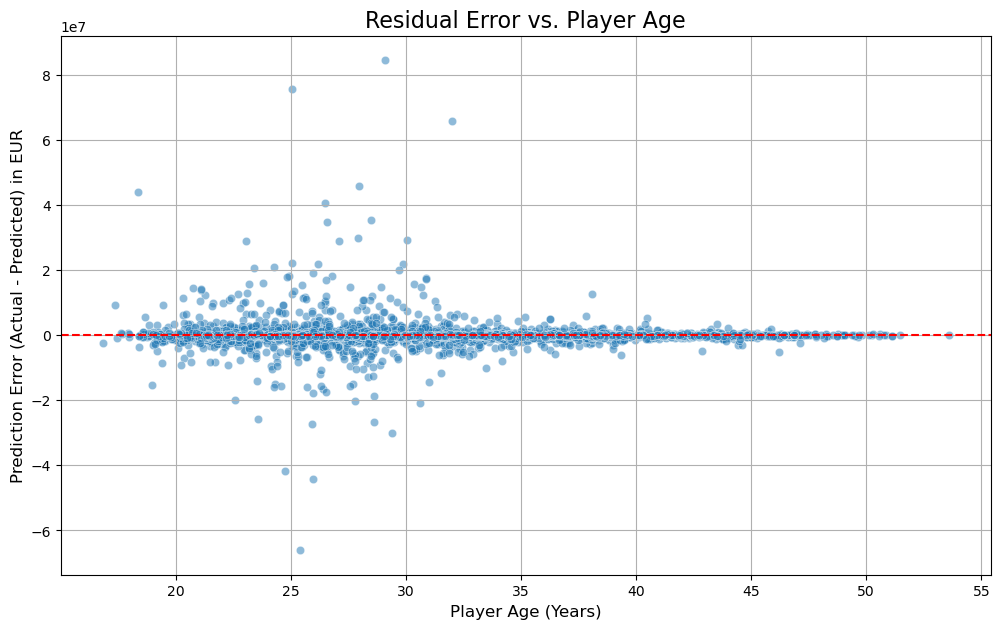

--- Top 20 Biggest Prediction Misses ---
                    name   age  actual_market_value  predicted_market_value  \
18989              Rodri 29.09       130,000,000.00           45,465,484.00   
19437    Vinicius Junior 25.04       200,000,000.00          124,229,856.00   
20406      Ferran Torres 25.40        28,000,000.00           94,080,224.00   
9295          Harry Kane 31.99        90,000,000.00           24,108,312.00   
17267      Marcus Thuram 27.97        75,000,000.00           29,231,832.00   
17536   Matthijs de Ligt 25.95        40,000,000.00           84,136,016.00   
29213      Ethan Nwaneri 18.35        55,000,000.00           10,978,616.00   
21178    Alphonso Davies 24.73        50,000,000.00           91,802,256.00   
21144   Martín Zubimendi 26.48        60,000,000.00           19,264,580.00   
14771     Nicolò Barella 28.46        80,000,000.00           44,565,772.00   
20546     Victor Osimhen 26.57        70,000,000.00           35,094,208.00   
20686   Lau

In [135]:
# 1. Access the trained XGBoost model and the preprocessor from the pipeline
xgb_model = xgb_pipeline5.named_steps['regressor']
preprocessor = xgb_pipeline5.named_steps['preprocessor']

# 2. Get the feature names after all transformations (like one-hot encoding)
# This is crucial for matching the scores to the correct feature names
feature_names = preprocessor.get_feature_names_out()

# 3. Get the feature importance scores from the model
importances = xgb_model.feature_importances_

# 4. Create a pandas Series for easy viewing and sorting
feature_importance_series = pd.Series(importances, index=feature_names)

# 5. Sort the values to see the most important features at the top
print("--- Top 15 Most Important Features (from XGBoost) ---")
print(feature_importance_series.nlargest(15))

# --- 1. Prepare Data for Analysis --
# Make predictions on the test set
y_pred = xgb_pipeline5.predict(X_test)

y_pred_eur = y_pred
y_test_eur = y_test

# Create a new DataFrame for analysis to avoid SettingWithCopyWarning
analysis_df = X_test.copy()
analysis_df['actual_market_value'] = y_test_eur
analysis_df['predicted_market_value'] = y_pred_eur
analysis_df['residual_error'] = analysis_df['actual_market_value'] - analysis_df['predicted_market_value']


# --- 2. Analyze the Residuals (Plotting) ---
# A residual plot shows the errors vs. a feature

plt.figure(figsize=(12, 7))
sns.scatterplot(x='age', y='residual_error', data=analysis_df, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Error vs. Player Age', fontsize=16)
plt.xlabel('Player Age (Years)', fontsize=12)
plt.ylabel('Prediction Error (Actual - Predicted) in EUR', fontsize=12)
plt.grid(True)
plt.show()


# --- 3. Examine the Biggest Misses ---
analysis_df = analysis_df.merge(players_df[['name']], left_index=True, right_index=True, how='left')

# Sort by the absolute error to find the biggest misses overall
analysis_df['abs_error'] = analysis_df['residual_error'].abs()
biggest_misses = analysis_df.sort_values('abs_error', ascending=False)

# Display the top 20 biggest prediction errors
print("--- Top 20 Biggest Prediction Misses ---")
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
print(biggest_misses[display_cols].head(20))


print("\n--- Top 10 Players the Model UNDERESTIMATED (Predicted too low) ---")
print(biggest_misses.sort_values('residual_error', ascending=False)[display_cols].head(10))

print("\n--- Top 10 Players the Model OVERESTIMATED (Predicted too high) ---")
print(biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10))

In [197]:
display_cols = ['name', 'age', 'actual_market_value', 'predicted_market_value', 'residual_error']
biggest_misses.sort_values('residual_error', ascending=True)[display_cols].head(10)

,name,age,actual_market_value,predicted_market_value,residual_error
20406,Ferran Torres,25.40,"28,000,000.00","94,080,224.00","-66,080,224.00"
17536,Matthijs de Ligt,25.95,"40,000,000.00","84,136,016.00","-44,136,016.00"
21178,Alphonso Davies,24.73,"50,000,000.00","91,802,256.00","-41,802,256.00"
10883,Timo Werner,29.39,"10,000,000.00","39,956,372.00","-29,956,372.00"
19400,Evan Ndicka,25.93,"25,000,000.00","52,251,004.00","-27,251,004.00"
16594,Franck Kessié,28.60,"20,000,000.00","46,621,560.00","-26,621,560.00"
25590,Ander Barrenetxea,23.58,"18,000,000.00","43,618,892.00","-25,618,892.00"
9373,Raheem Sterling,30.63,"15,000,000.00","35,783,316.00","-20,783,316.00"
20882,Nikola Milenković,27.79,"28,000,000.00","48,302,404.00","-20,302,404.00"
26547,Elye Wahi,22.56,"25,000,000.00","45,036,304.00","-20,036,304.00"


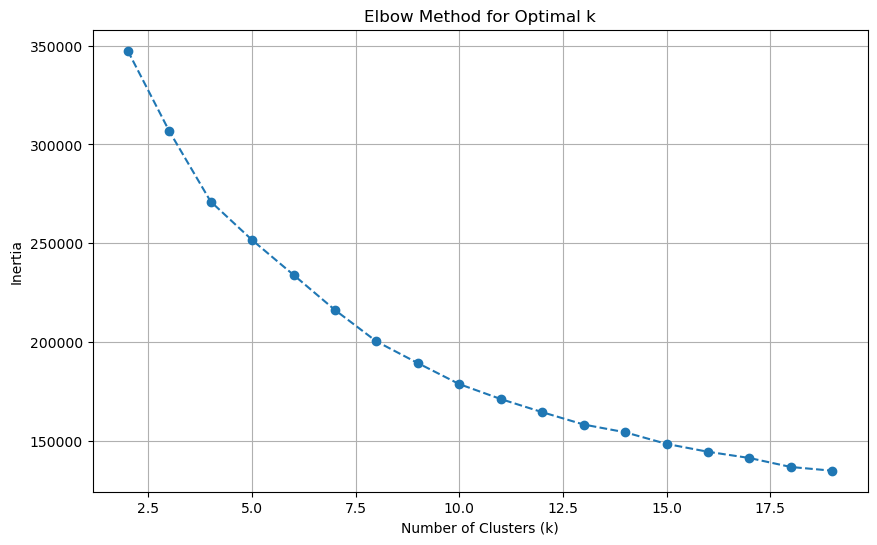

In [149]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# --- 1. Select and Prepare the Data ---
#Going to sum up club_1 to club_13 for clustering. This gives a score that conveys the quality of teams the player has played for, but doesn't overweight them 
#since clustering weighs each feature the same

club_cols = [
    'club_1', 'club_2', 'club_3', 'club_4', 'club_5', 'club_6', 'club_7',
    'club_8', 'club_9', 'club_10', 'club_11', 'club_12', 'club_13'
]

model5_with_id['club_sum'] = model5_with_id[club_cols].sum(axis=1)

numerical_features = [
    'height_in_cm', 'contract_days_remaining', 'yellow_cards',
    'goals', 'assists', 'minutes_played', 'red_cards', 'club_sum',
    'age', 'age_peak_diff_sq', 'goals_per_90',
    'assists_per_90','goals_adjusted_y', 'assists_adjusted_y',
    'minutes_played_adjusted_y'
]

# Create a new DataFrame with only the features for clustering
cluster_df = model5_with_id[numerical_features].copy()

# --- 2. Create a Preprocessing Pipeline ---
# K-Means requires data to be scaled and have no missing values.
# The imputer handles any NaNs, and the scaler standardizes the features.
preprocessing_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Apply the preprocessing to your data
X_processed = preprocessing_pipeline.fit_transform(cluster_df)


# --- 3. Find the Optimal Number of Clusters (k) using the Elbow Method ---
# We calculate the inertia (sum of squared distances to the closest centroid)
# for a range of k values. The "elbow" point is the optimal k.
inertia_scores = []
k_range = range(2, 20) # Test k from 2 to 20 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_processed)
    inertia_scores.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [174]:
# --- 4. Fit the Final K-Means Model ---
# Based on the elbow plot, choose the optimal number of clusters. We can probably go beyond 10 and still get meaningful distinction, but too many starts to create very specific categories
optimal_k = 10
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_processed)

# Add the cluster labels back to your original DataFrame
model5_with_id['cluster'] = kmeans_final.labels_
print(f"\nSuccessfully assigned players to {optimal_k} clusters.")


# --- 5. Analyze the Clusters ---
# Calculate the mean of the features for each cluster to understand their characteristics.
cluster_summary = model5_with_id.groupby('cluster')[numerical_features].mean().round(2)

print("\n--- Cluster Summary (Average Stats per Cluster) ---")
# Transposing (.T) often makes the summary easier to read
print(cluster_summary.T)


Successfully assigned players to 10 clusters.

--- Cluster Summary (Average Stats per Cluster) ---
cluster                          0       1         2         3       4  \
height_in_cm                187.77  176.42    184.12    180.65  181.00   
contract_days_remaining    -252.77 -260.81    118.05    247.33 -758.00   
yellow_cards                  2.12    2.16     48.87     49.73    0.00   
goals                         0.82    1.04     13.56    203.98    0.00   
assists                       0.48    1.01     14.37    107.38    1.00   
minutes_played            1,028.45  933.81 20,563.95 33,516.15    1.00   
red_cards                     0.06    0.04      1.64      1.21    0.00   
club_sum                    104.12  119.82    714.65  1,130.98  178.00   
age                          29.16   28.83     34.51     34.43   23.11   
age_peak_diff_sq             25.90   23.11     75.90     69.52   15.13   
goals_per_90                  0.05    0.07      0.06      0.55    0.00   
assists_per_

Used Gemini to help me quickly summarize clusters

Tier 1: The Superstars & Elite Prospects ⭐
Cluster 3 (The Elite Superstars): This is your most valuable group. They are defined by having the highest values in every key performance metric: goals, assists, minutes_played, club_sum, and all the adjusted stats. These are established, world-class veterans who have had legendary careers.

Cluster 6 (The Young Prospects): This is your youngest group (average age 23.8) and they have by far the longest contract_days_remaining. Their career stats are still low, but their long contracts and youth mark them as the high-potential assets in the dataset.

Tier 2: The Established Veterans ✅
Cluster 9 (The Established Veterans): This group has high goals, assists, and minutes_played, but they are a clear step below the "Elite Superstars" in Cluster 3. They represent the core group of reliable, high-performing professionals who have had long, successful careers.

Cluster 2 (The Workhorse Veterans): These players have very high minutes_played and the most yellow_cards and red_cards, but lower goal/assist numbers. These are your long-serving, hard-working defensive midfielders and defenders.

Tier 3: The Specialists & End-of-Career Players 🛡️
Cluster 8 (The Elder Statesmen): This is by far the oldest group (average age 41.9), with very low performance stats. These players are at the very end of their careers, likely having transitioned to minor roles or coaching.

Cluster 7 (The Mid-Career Professionals): This group represents players in their early 30s with solid but not spectacular career stats. They have a decent amount of playing time and are reliable squad members.

Tier 4: The Fringe & Inactive Players 📉
Cluster 0 & 1 (The Fringe Players): These two clusters have by far the lowest minutes_played and minimal performance stats. They represent players who get very little playing time, are frequently injured, or are on the fringes of their squads.

Cluster 4 & 5 (The Inactive/Anomalies): These clusters have almost zero minutes_played. They are statistical anomalies, likely representing players who made one or two appearances, perhaps got a single stat, and were never seen again. They are effectively inactive players in the dataset.

In [172]:
full_predict5 = xgb_pipeline5.predict(model5_df)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [173]:
cluster_counts = model5_with_id['cluster'].value_counts()
cluster_counts

cluster
0    8643
1    8522
8    4104
7    3750
6    3694
2    1166
9     647
3      52
5       5
4       1
Name: count, dtype: int64

In [177]:
# --- Find Outliers in Each Cluster ---
model5_with_id['predicted_market_value'] = full_predict5

# Calculate the z-score for each player's market value within their cluster.
# A high z-score (e.g., > 2.5) indicates an outlier.
model5_with_id['value_zscore'] = model5_with_id.groupby('cluster')['market_value_in_eur'].transform(
    lambda x: (x - x.mean()) / x.std()
)

model5_with_id['predict_zscore'] = model5_with_id.groupby('cluster')['predicted_market_value'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Sort by the z-score to find the biggest outliers
outliers_df = model5_with_id.sort_values('value_zscore', ascending=False)

# Display the top 50 most overvalued players relative to their cluster peers
print("\n--- Top 50 Outliers (Most Valuable vs. Cluster Average) ---")
display_cols = ['name', 'cluster', 'market_value_in_eur', 'value_zscore', 'predicted_market_value', 'predict_zscore']
outliers_df = pd.merge(left=outliers_df, right=players_df[['player_id', 'name']], on='player_id', how='left')
outliers_df[display_cols].head(50)


--- Top 50 Outliers (Most Valuable vs. Cluster Average) ---


,name,cluster,market_value_in_eur,value_zscore,predicted_market_value,predict_zscore
0,Ethan Nwaneri,1,"55,000,000.00",41.21,"10,978,616.00",12.65
1,Giorgi Mamardashvili,0,"30,000,000.00",28.40,"12,248,586.00",16.63
2,Vitor Roque,1,"30,000,000.00",22.32,"16,416,982.00",19.19
3,Lamine Yamal,7,"180,000,000.00",21.52,"168,019,056.00",21.74
4,Illan Meslier,0,"20,000,000.00",18.80,"19,212,330.00",26.42
5,Marcin Bulka,0,"20,000,000.00",18.80,"8,546,899.00",11.43
6,Alberto Moleiro,1,"25,000,000.00",18.55,"13,673,038.00",15.89
7,Andrey Santos,1,"25,000,000.00",18.55,"11,623,277.00",13.43
8,Thiago Almada,1,"25,000,000.00",18.55,"3,946,578.00",4.21
9,Tom Bischof,1,"25,000,000.00",18.55,"19,959,250.00",23.45


In [178]:
outliers_df[display_cols].sort_values('predict_zscore', ascending=False).head(50)

,name,cluster,market_value_in_eur,value_zscore,predicted_market_value,predict_zscore
4,Illan Meslier,0,"20,000,000.00",18.80,"19,212,330.00",26.42
15,Facundo Buonanotte,1,"22,000,000.00",16.28,"20,334,228.00",23.90
9,Tom Bischof,1,"25,000,000.00",18.55,"19,959,250.00",23.45
13,Renato Veiga,0,"18,000,000.00",16.88,"15,894,322.00",21.76
3,Lamine Yamal,7,"180,000,000.00",21.52,"168,019,056.00",21.74
2,Vitor Roque,1,"30,000,000.00",22.32,"16,416,982.00",19.19
14,Julio Enciso,1,"22,000,000.00",16.28,"16,336,558.00",19.09
1,Giorgi Mamardashvili,0,"30,000,000.00",28.40,"12,248,586.00",16.63
16,Cole Palmer,6,"130,000,000.00",15.95,"121,719,952.00",16.45
619,Andrea Pirlo,8,"1,000,000.00",2.80,"6,016,819.00",16.26


In [179]:
outliers_df['diff'] = outliers_df['predict_zscore'] - outliers_df['value_zscore']

outliers_df[display_cols + ['diff']].sort_values('diff', ascending=False).head(20)

,name,cluster,market_value_in_eur,value_zscore,predicted_market_value,predict_zscore,diff
619,Andrea Pirlo,8,"1,000,000.00",2.80,"6,016,819.00",16.26,13.46
10173,Leonardo Ulloa,8,"200,000.00",-0.13,"4,375,783.50",11.64,11.76
2562,Florian Müller,0,"1,200,000.00",0.75,"6,716,172.50",8.86,8.11
19879,Willy Caballero,8,"150,000.00",-0.31,"2,899,969.50",7.48,7.79
4,Illan Meslier,0,"20,000,000.00",18.80,"19,212,330.00",26.42,7.62
15,Facundo Buonanotte,1,"22,000,000.00",16.28,"20,334,228.00",23.90,7.62
6019,Zvonimir Vukic,8,"250,000.00",0.06,"2,870,022.75",7.39,7.34
2849,Claudio Pizarro,8,"400,000.00",0.61,"3,055,612.25",7.92,7.31
2404,Mario Martín,1,"1,500,000.00",0.79,"7,011,330.50",7.89,7.10
560,Michael Carrick,8,"1,000,000.00",2.80,"3,712,014.25",9.77,6.97


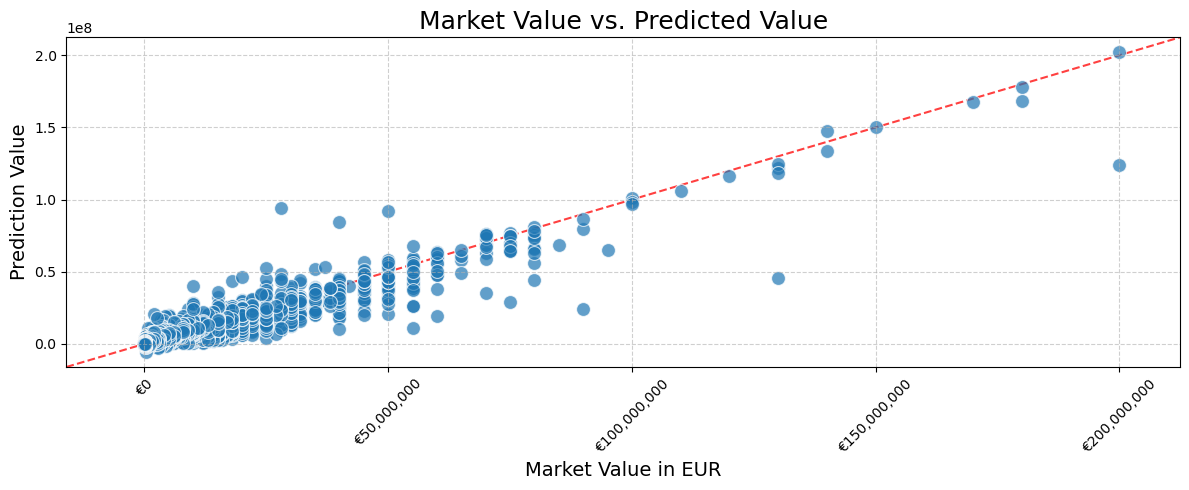

In [214]:
# --- Create the Scatter Plot ---
plt.figure(figsize=(12, 5))
plot = sns.scatterplot(
    x='market_value_in_eur', 
    y='predicted_market_value', 
    data=outliers_df,
    alpha=0.7, # Use transparency to see overlapping points
    s=100      # Adjust marker size
)

# This line represents a perfect prediction (y=x)
lims = [
    np.min([plot.get_xlim(), plot.get_ylim()]),  # min of both axes
    np.max([plot.get_xlim(), plot.get_ylim()]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)
plot.set_xlim(lims)
plot.set_ylim(lims)

# --- Customize the Plot ---
plt.title('Market Value vs. Predicted Value', fontsize=18)
plt.xlabel('Market Value in EUR', fontsize=14)
plt.ylabel('Prediction Value', fontsize=14)

# Format x-axis labels to be more readable
from matplotlib.ticker import FuncFormatter
plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'€{x:,.0f}'))
plt.xticks(rotation=45)


plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

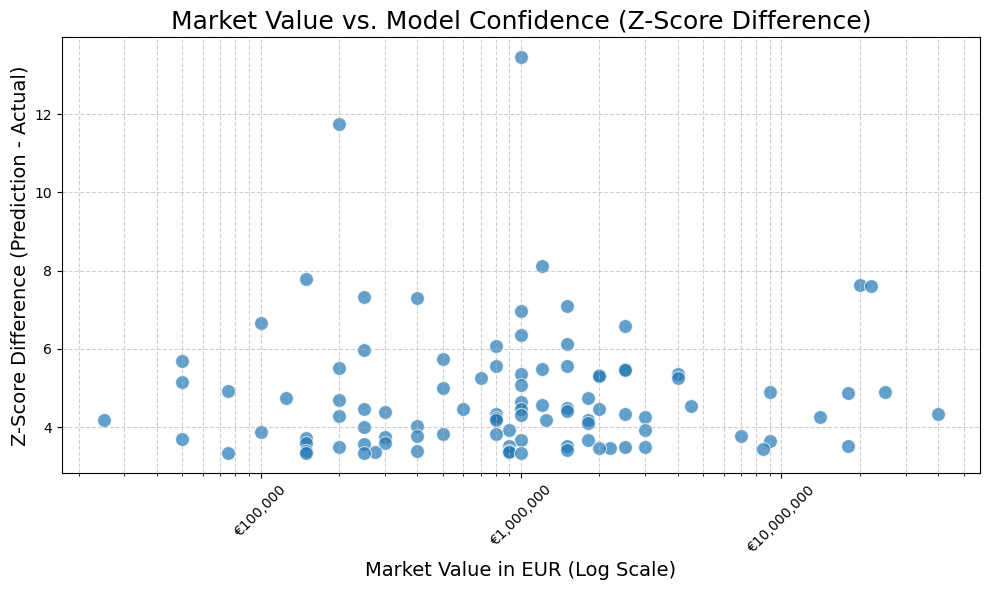

In [215]:
# --- Create the Scatter Plot ---
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    x='market_value_in_eur', 
    y='diff', 
    data=outliers_df.sort_values('diff', ascending=False).head(100),
    alpha=0.7, # Use transparency to see overlapping points
    s=100      # Adjust marker size
)

# --- Customize the Plot ---
plt.title('Market Value vs. Model Confidence (Z-Score Difference)', fontsize=18)
plt.xlabel('Market Value in EUR (Log Scale)', fontsize=14)
plt.ylabel('Z-Score Difference (Prediction - Actual)', fontsize=14)

# Use a log scale for the x-axis to better visualize the wide range of market values
plot.set_xscale('log')

# Format x-axis labels to be more readable
from matplotlib.ticker import FuncFormatter
plot.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'€{x:,.0f}'))
plt.xticks(rotation=45)


plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

/var/folders/2q/dn_zknnx74l18v8wm2js8_540000gn/T/ipykernel_86683/3915309202.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_per_cluster = outliers_df.groupby('cluster').apply(lambda x: x.nlargest(1, 'diff')).reset_index(drop=True)
/var/folders/2q/dn_zknnx74l18v8wm2js8_540000gn/T/ipykernel_86683/3915309202.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom_per_cluster = outliers_df.groupby(

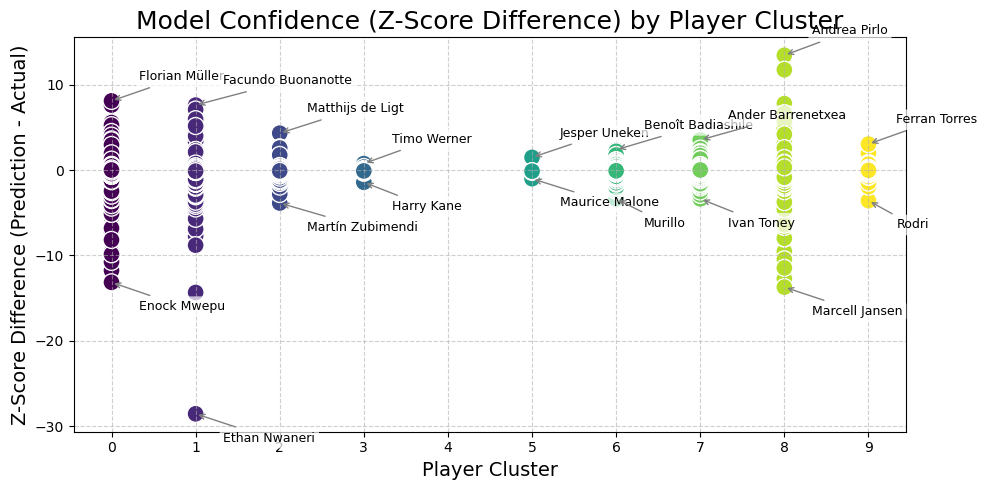

In [217]:
# --- 2. Create the Scatter Plot ---
plt.figure(figsize=(10, 5))
plot = sns.scatterplot(
    x='cluster', 
    y='diff', 
    data=outliers_df,
    hue='cluster', # Color points by cluster for better readability
    palette='viridis',
    s=150,      # Adjust marker size
    legend=False # Hide the legend as the x-axis already shows the cluster
)

# --- 3. Identify and Label Top/Bottom Outliers per Cluster ---
# Create a DataFrame containing only the players we want to label
top_per_cluster = outliers_df.groupby('cluster').apply(lambda x: x.nlargest(1, 'diff')).reset_index(drop=True)
bottom_per_cluster = outliers_df.groupby('cluster').apply(lambda x: x.nsmallest(1, 'diff')).reset_index(drop=True)
players_to_label = pd.concat([top_per_cluster, bottom_per_cluster]).drop_duplicates().reset_index(drop=True)

# --- 4. Add Player Names as Annotations with Adjusted Positions ---
# Group the labels to process them cluster by cluster
grouped_labels = players_to_label.groupby('cluster')

for cluster_id, group in grouped_labels:
    # Sort by 'diff' to handle top and bottom consistently
    sorted_group = group.sort_values('diff', ascending=False).reset_index(drop=True)
    
    # Define vertical offsets to separate labels
    top_offset = 15
    bottom_offset = -20
    
    # Label top player
    if len(sorted_group) >= 1:
        player = sorted_group.iloc[0]
        plt.annotate(player['name'],
                     (player['cluster'], player['diff']),
                     xytext=(20, top_offset),
                     textcoords='offset points',
                     ha='left',
                     arrowprops=dict(arrowstyle="->", color='gray'),
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))

    # Label bottom player (if there is more than 1 unique player in the group)
    if len(sorted_group) > 1:
        player = sorted_group.iloc[-1]
        plt.annotate(player['name'],
                     (player['cluster'], player['diff']),
                     xytext=(20, bottom_offset),
                     textcoords='offset points',
                     ha='left',
                     arrowprops=dict(arrowstyle="->", color='gray'),
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.7))


# --- 5. Customize the Plot ---
plt.title('Model Confidence (Z-Score Difference) by Player Cluster', fontsize=18)
plt.xlabel('Player Cluster', fontsize=14)
plt.ylabel('Z-Score Difference (Prediction - Actual)', fontsize=14)

# Ensure x-axis ticks are integers representing the clusters
plt.xticks(ticks=sorted(outliers_df['cluster'].unique()))

plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()


### An important distinction

Since the target is subjective, the XGBoost model isn't exactly learning to predict an objective, "true" value. Instead, it's learning to replicate the decision-making process of the human experts who created the estimates.

The XGBoost model is essentially learning the set of unwritten rules that experts use to assign these values. It has learned that the experts heavily weigh factors like age, performance in top leagues, contract length, etc., and can apply that same logic consistently and instantly to any player.

Without the human biases that might favor certain teams or nationalities, it can generate valuations for thousands of players instantly.

Error analysis and outlier detection are not necessarily mistakes. They are disagreements with the expert consensus. These disagreements are where the most valuable insights are found.

Undervalued Players: If the model predicts a player's value to be much higher than the expert estimate, it might have identified a "hidden gem" that the market is undervaluing based on their stats.

Overvalued Players: If the model predicts a much lower value, it might be flagging a player who is overhyped and whose stats don't justify their current market value.

In [181]:
outliers_df[['name', 'cluster', 'diff']].sort_values('diff', ascending=False).head(20)

,name,cluster,diff
619,Andrea Pirlo,8,13.46
10173,Leonardo Ulloa,8,11.76
2562,Florian Müller,0,8.11
19879,Willy Caballero,8,7.79
4,Illan Meslier,0,7.62
15,Facundo Buonanotte,1,7.62
6019,Zvonimir Vukic,8,7.34
2849,Claudio Pizarro,8,7.31
2404,Mario Martín,1,7.10
560,Michael Carrick,8,6.97


In [185]:
#Save model
joblib.dump(xgb_pipeline5, 'player_value_model.pkl')

print("Model saved successfully as 'player_value_model.pkl'")

Model saved successfully as 'player_value_model.pkl'


In [195]:
# Group by the 'cluster' column, then find the 5 largest 'diff' values in each group
top_5_per_cluster = outliers_df[['name', 'diff', 'predicted_market_value', 'market_value_in_eur']].groupby(outliers_df['cluster']).apply(
    lambda x: x.nlargest(5, 'diff')
).reset_index()

top_5_per_cluster.drop(columns=['level_1']).head(46)

,cluster,name,diff,predicted_market_value,market_value_in_eur
0,0,Florian Müller,8.11,"6,716,172.50","1,200,000.00"
1,0,Illan Meslier,7.62,"19,212,330.00","20,000,000.00"
2,0,João Virgínia,5.57,"4,636,588.50","800,000.00"
3,0,Matheus Fernandes,5.56,"5,107,248.50","1,500,000.00"
4,0,Lucas Ribeiro,5.50,"4,855,795.50","1,200,000.00"
5,1,Facundo Buonanotte,7.62,"20,334,228.00","22,000,000.00"
6,1,Mario Martín,7.10,"7,011,330.50","1,500,000.00"
7,1,Brandon Williams,6.60,"7,227,503.50","2,500,000.00"
8,1,Luke Chambers,6.14,"6,214,322.00","1,500,000.00"
9,1,Marco Tumminello,5.97,"5,285,282.00","250,000.00"


This project has successfully created a sophisticated, dual-model system for player analysis. By combining unsupervised clustering with a supervised prediction model, we have developed a powerful tool for talent identification.

The unsupervised K-Means model first segments players into distinct statistical archetypes, allowing scouts to filter for specific profiles like "Young Prospects" or "Peak Performers." Within these statistically similar groups, our tuned XGBoost model provides a "recommendation score" by comparing its data-driven valuation against expert estimates. This methodology enables clubs to quickly identify players who are not just statistical outliers, but potential "hidden gems" or undervalued assets that fit their strategic needs, providing a significant competitive advantage in the transfer market.

For example, if we are looking at prospects, Benoît Badiashile is a best-in-class 40.1M Eur market value but would likely sell in the region of 25M Eur. This is potentially 15M profit with a young player that would likely increase in value over time.

## Conclusion

### Key Findings
The final predictive model, a tuned XGBoost Regressor trained on estimated market value, achieved a strong R-squared of 0.72. This indicates that the model can explain 72% of the variance in player market value. Analysis of the model's feature importances revealed that the most significant drivers of value are a player's league and club prestige, their remaining contract length, their age, and the engineered performance metrics that were weighted by opponent and competition quality. The K-Means clustering was also highly effective, successfully identifying distinct and logical player archetypes, from "Elite Superstars" to "Young Prospects" and "Defensive Veterans."

Practical Applications
The primary application of this system is as a data-driven tool for player recruitment. A club's scouting department can use the K-Means clusters to first identify a pool of players that match a desired statistical profile. They can then use the XGBoost model's predictions to rank these players, specifically looking for those whose model-predicted value is significantly higher than their current market estimate. This provides a quantifiable method for identifying potentially undervalued targets. Furthermore, the system can be used for internal squad analysis to assess whether a player's current market value is justified by their underlying performance data.

Future Work
To further enhance the model's accuracy, future iterations should focus on incorporating more granular data. Integrating advanced performance metrics like "Expected Goals (xG)" or detailed injury history could provide a richer picture of a player's quality and risk profile. Additionally, exploring more advanced feature engineering techniques, such as target encoding for high-cardinality features like club names, could yield further performance gains. Finally, the entire pipeline could be deployed as an interactive dashboard, allowing users to dynamically filter clusters and explore player valuations in real-time.